In [47]:
%load_ext autoreload
%autoreload 2
# import bandit from code folder

# from code import bandit
import sys
sys.path.append("../code")
import read_data
import bandit
import numpy as np
import seaborn as sns
import networkx as nx
import graphviz as gv
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# for sioux falls, read all the files
net_file_name = '../TransportationNetworks/SiouxFalls/SiouxFalls_net.tntp'
num_nodes, num_arcs, arc_set, free_flow_time, capacity = read_data.report_net_data_tntp(net_file_name)
origin_node = [6 - 1, 10 - 1, 23 - 1]
dest_node = [1 - 1, 13 - 1, 18 - 1, 20 - 1]
trip_file_name = '../TransportationNetworks/SiouxFalls/SiouxFalls_trips.tntp'
demand = read_data.read_flow_data_trip_tntp(trip_file_name, origin_node)
bpr_params = [0.15, 4]
# solve the static model
shortest_path_per_node, _ = read_data.find_shortest_path(free_flow_time, origin_node, dest_node)
# convert shortest path to arc set
shortest_path = {}
for i in origin_node:
    path = shortest_path_per_node[i]
    for j in range(len(path) - 1):
        cur_link = (path[j], path[j + 1])
        if cur_link not in shortest_path.keys():
            shortest_path[cur_link] = [i]
        else:
            shortest_path[cur_link].append(i)

In [49]:
# assign parameters to network structure
network_structure = {
    'arc_set': arc_set,
    'origin_node': origin_node,
    'dest_node': dest_node,
    'num_nodes': num_nodes,
    'bpr_params': bpr_params,
    'demand': demand,
    'capacity': capacity,
    'free_flow_time': free_flow_time,
    'shortest_path': shortest_path
}

In [114]:
# define trust list
trust_list = np.arange(0.1, 1.1, 0.2)
# define an optimizer from bandit
epsilon_greedy_opt = bandit.GreedyOptimizer(network_structure, 0.7)
# define bandit list
epsilon_greedy_opt.build_bandit(trust_list)

In [51]:
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})

In [100]:
# run optimization
max_iter = 1000
epsilon_greedy_opt.set_true_trust_rate(0.7, 1e-3)
actions, travel_time, total_time_bandit, pull_time_bandit, opt_time, sample_trust_list = epsilon_greedy_opt.run_ucb(max_iter)

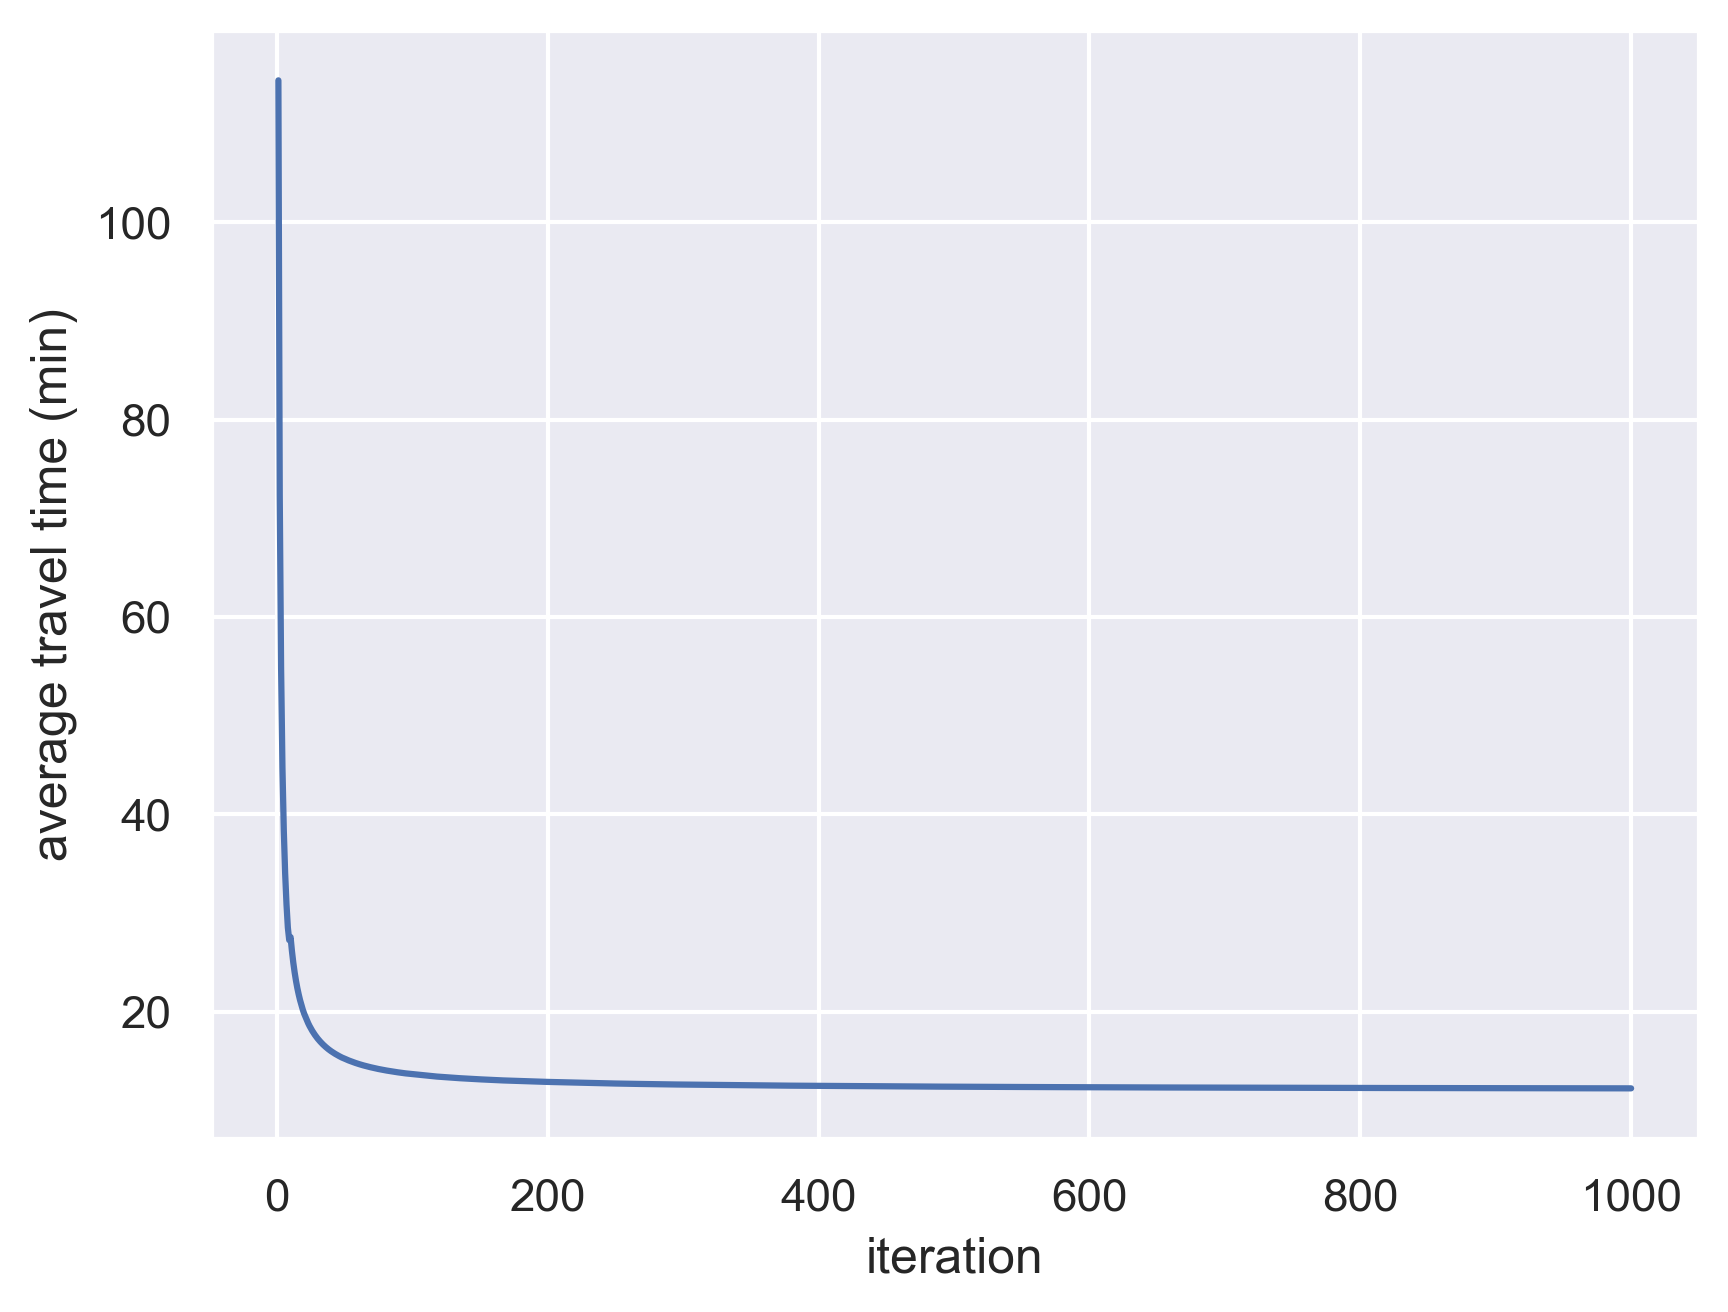

In [101]:
# plot the travel time
cumulative_ave = np.cumsum(travel_time) * 0.6 / (np.arange(max_iter) + 1)
sns.set_style("darkgrid")
# set dpi of figure
sns.set(rc={'figure.dpi': 300})
# add x label and y label by sns, with point at each data
ax = sns.lineplot(x=np.arange(max_iter) + 1, y=cumulative_ave)
ax.set(xlabel='iteration', ylabel='average travel time (min)')
# save the figure
fig = ax.get_figure()
fig.savefig('bandit_figure/sioux_falls_iteration_ucb.png')

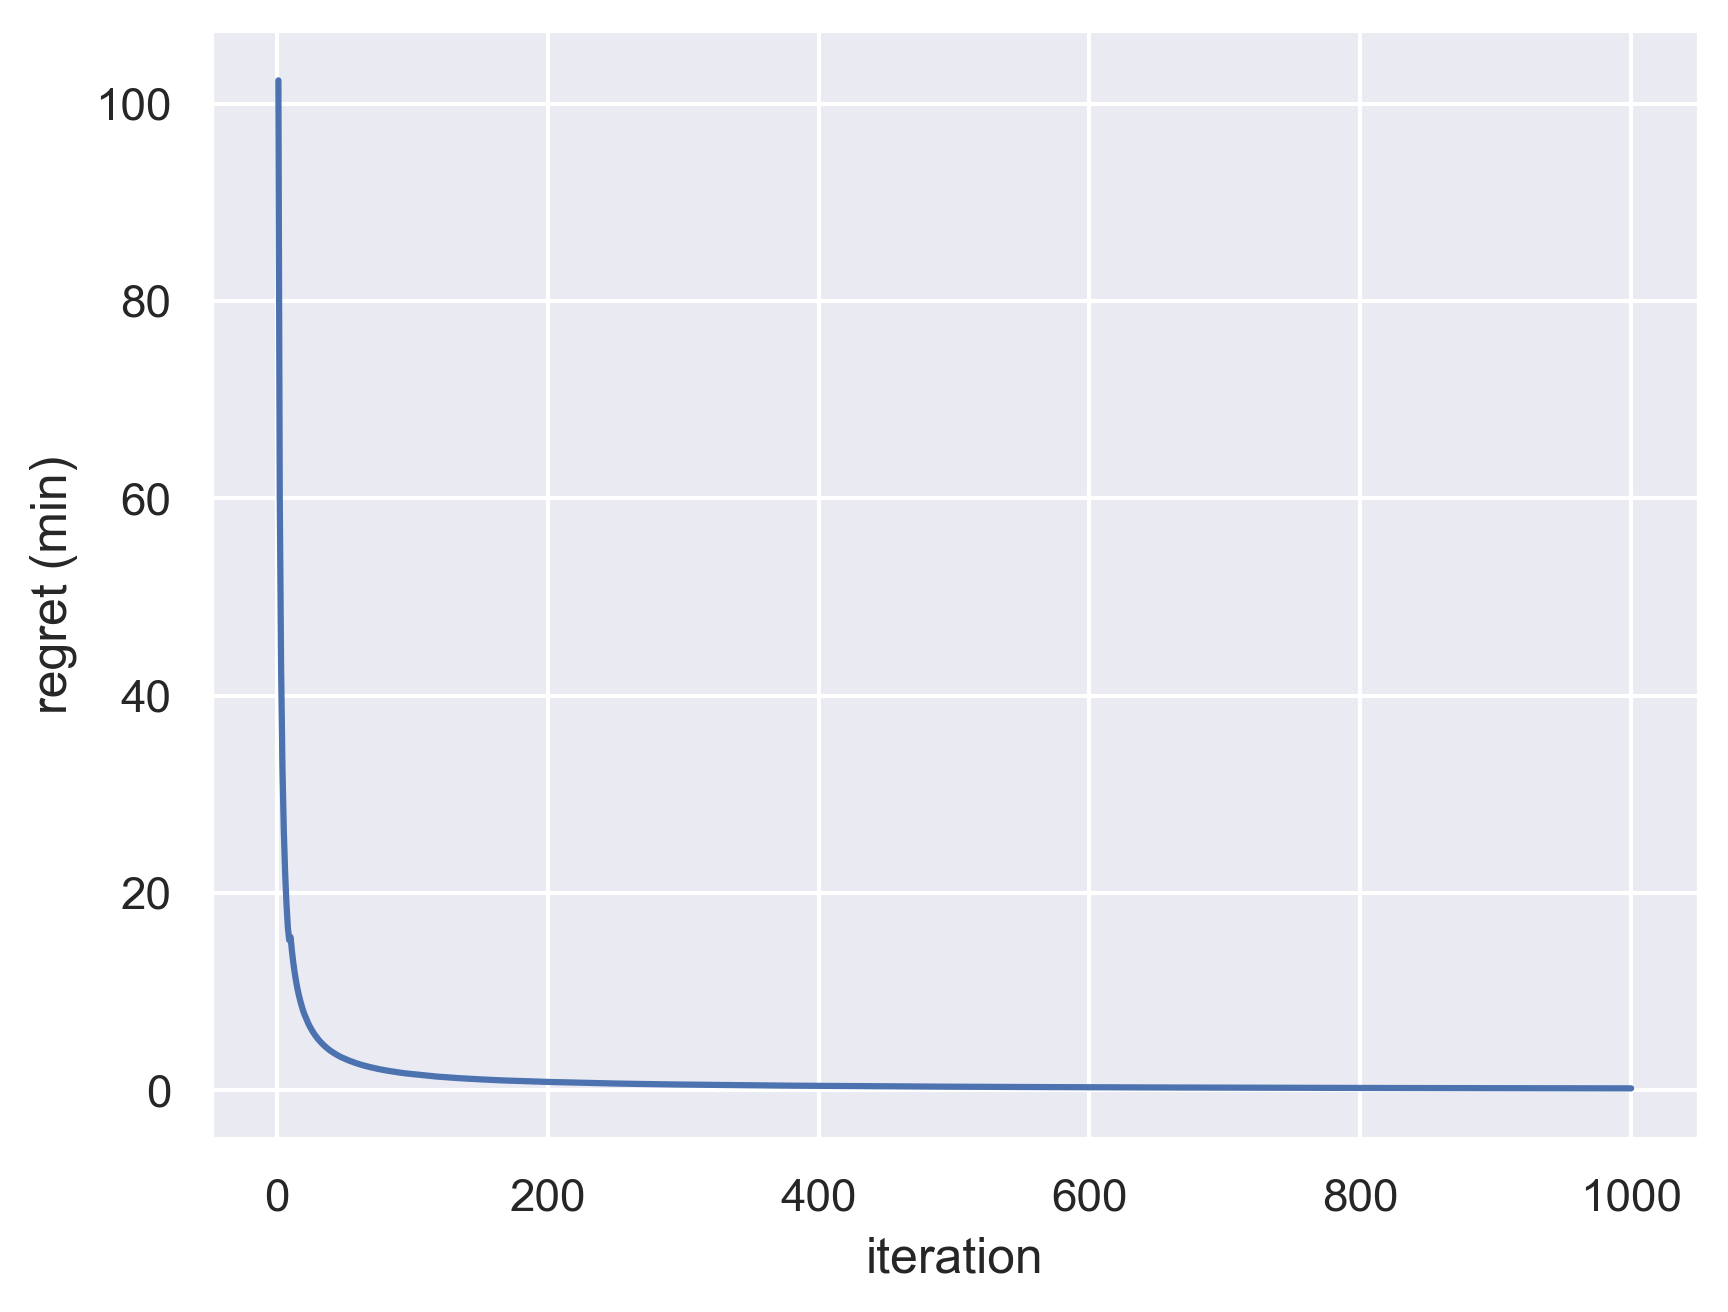

In [102]:
# plot the regret
regret = cumulative_ave - opt_time * 0.6
ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret)
ax.set(xlabel='iteration', ylabel='regret (min)')
# save the figure
fig = ax.get_figure()
fig.savefig('bandit_figure/sioux_falls_regret_ucb.png')

In [66]:
opt_time * 0.6

12.034846025000368

In [105]:
# test other trust rates
max_iter = 1000
epsilon_greedy_opt.set_true_trust_rate(0.32, 1e-3)
actions, travel_time, total_time_bandit, pull_time_bandit, opt_time, sample_trust_list = epsilon_greedy_opt.run_ucb(max_iter)

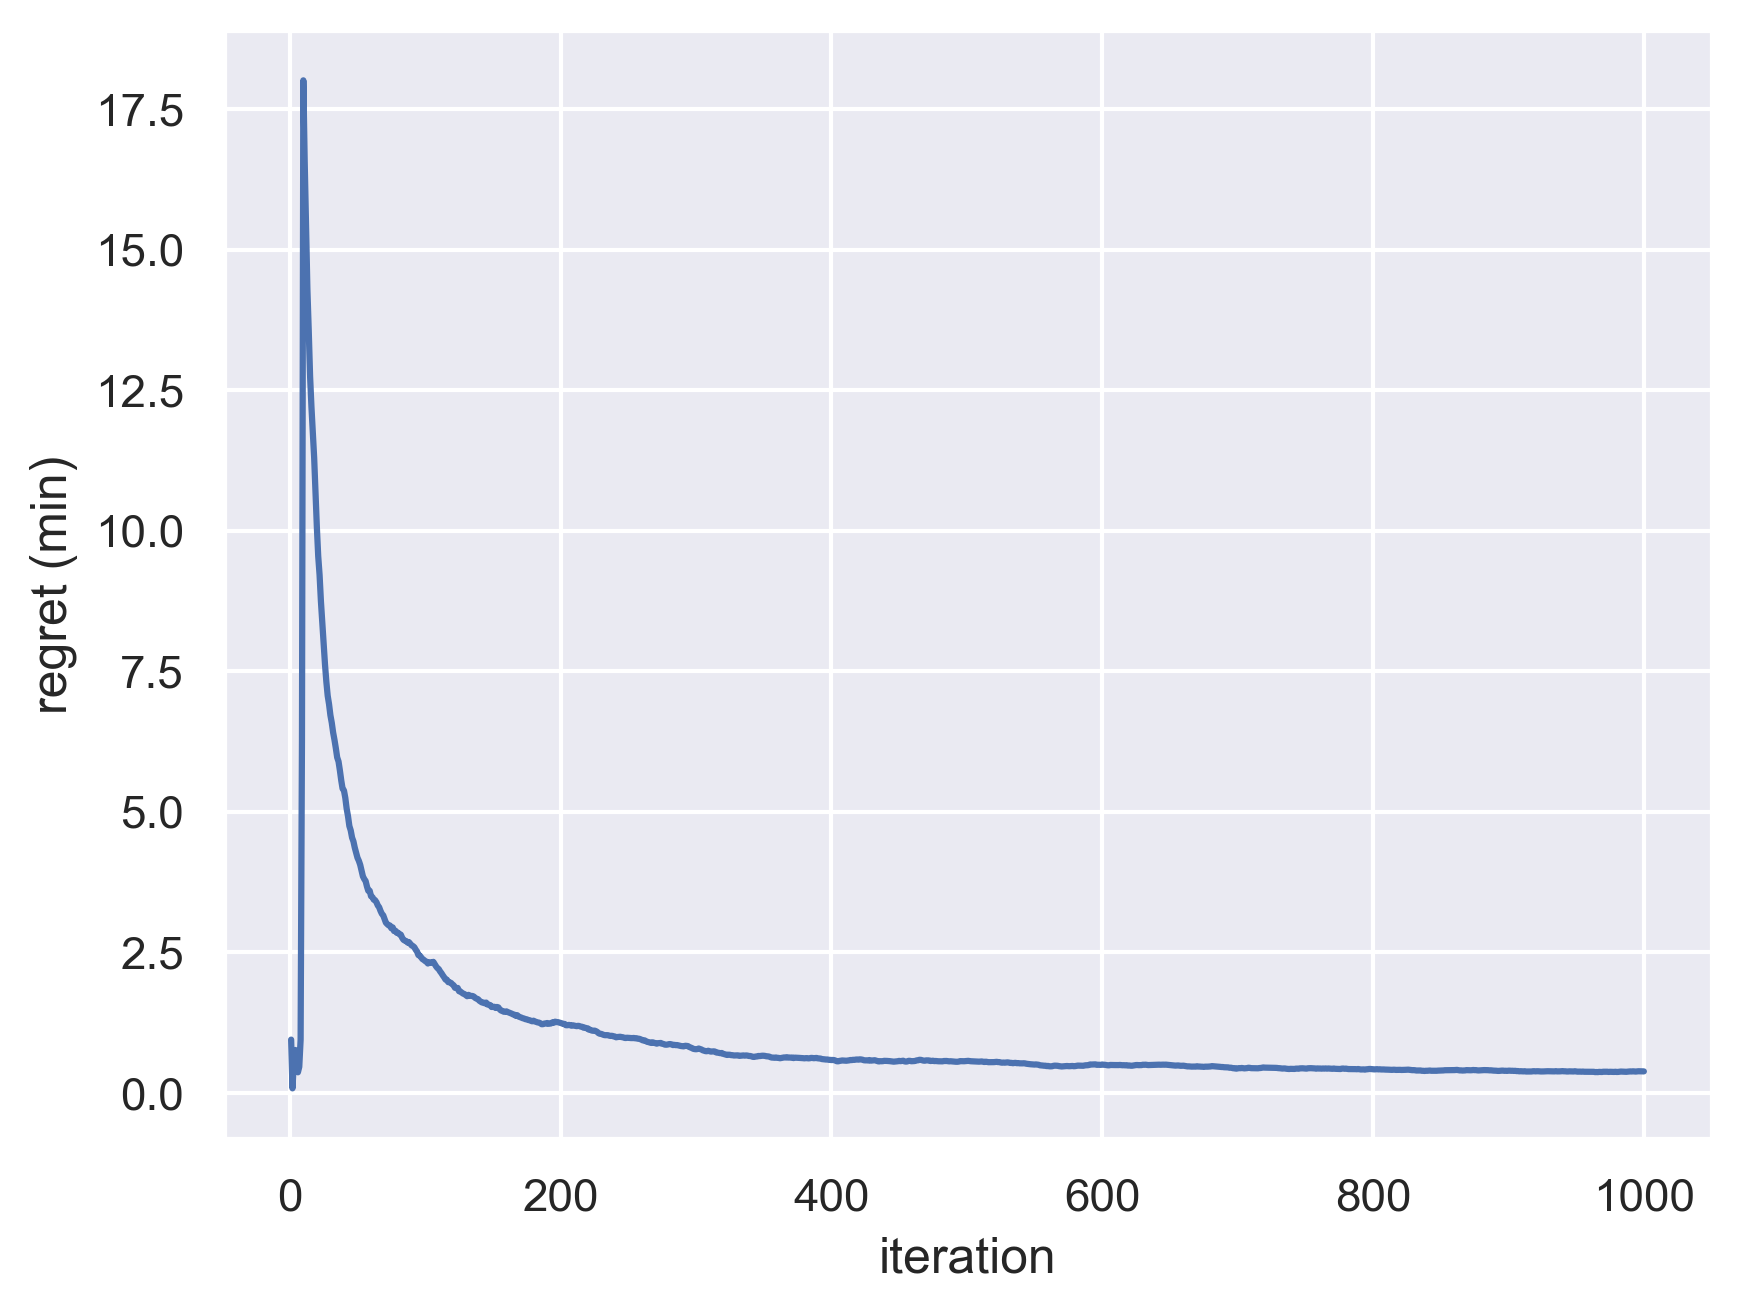

In [107]:
# plot the regret
regret = np.cumsum(travel_time) * 0.6 / (np.arange(max_iter) + 1) - opt_time * 0.6
ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret)
ax.set(xlabel='iteration', ylabel='regret (min)')
# save the figure
fig = ax.get_figure()
fig.savefig('bandit_figure/sioux_falls_regret_trust_0p32_ucb.png')




In [57]:
opt_time * 0.6

271.37243552606

In [90]:
total_time_bandit / pull_time_bandit


array([462.75756039, 453.25108009, 453.98578537, 466.02236946,
       459.00203972, 458.84187002, 462.30514861, 462.90111187,
       532.32473473, 669.56527386])

In [91]:
np.std(sample_trust_list)

0.009930354879831441

In [92]:
epsilon_greedy_opt.true_trust_rate_std


0.01

In [109]:
# test for three different trust rates
trust_list = [0.13, 0.48, 0.8]
actions, travel_time, total_time_bandit, pull_time_bandit, opt_time, sample_trust_list = {}, {}, {}, {}, {}, {}
for trust in trust_list:
    max_iter = 1000
    epsilon_greedy_opt.set_true_trust_rate(trust, 1e-3)
    actions[trust], travel_time[trust], total_time_bandit[trust], \
    pull_time_bandit[trust], opt_time[trust], sample_trust_list[trust] = epsilon_greedy_opt.run_ucb(max_iter)

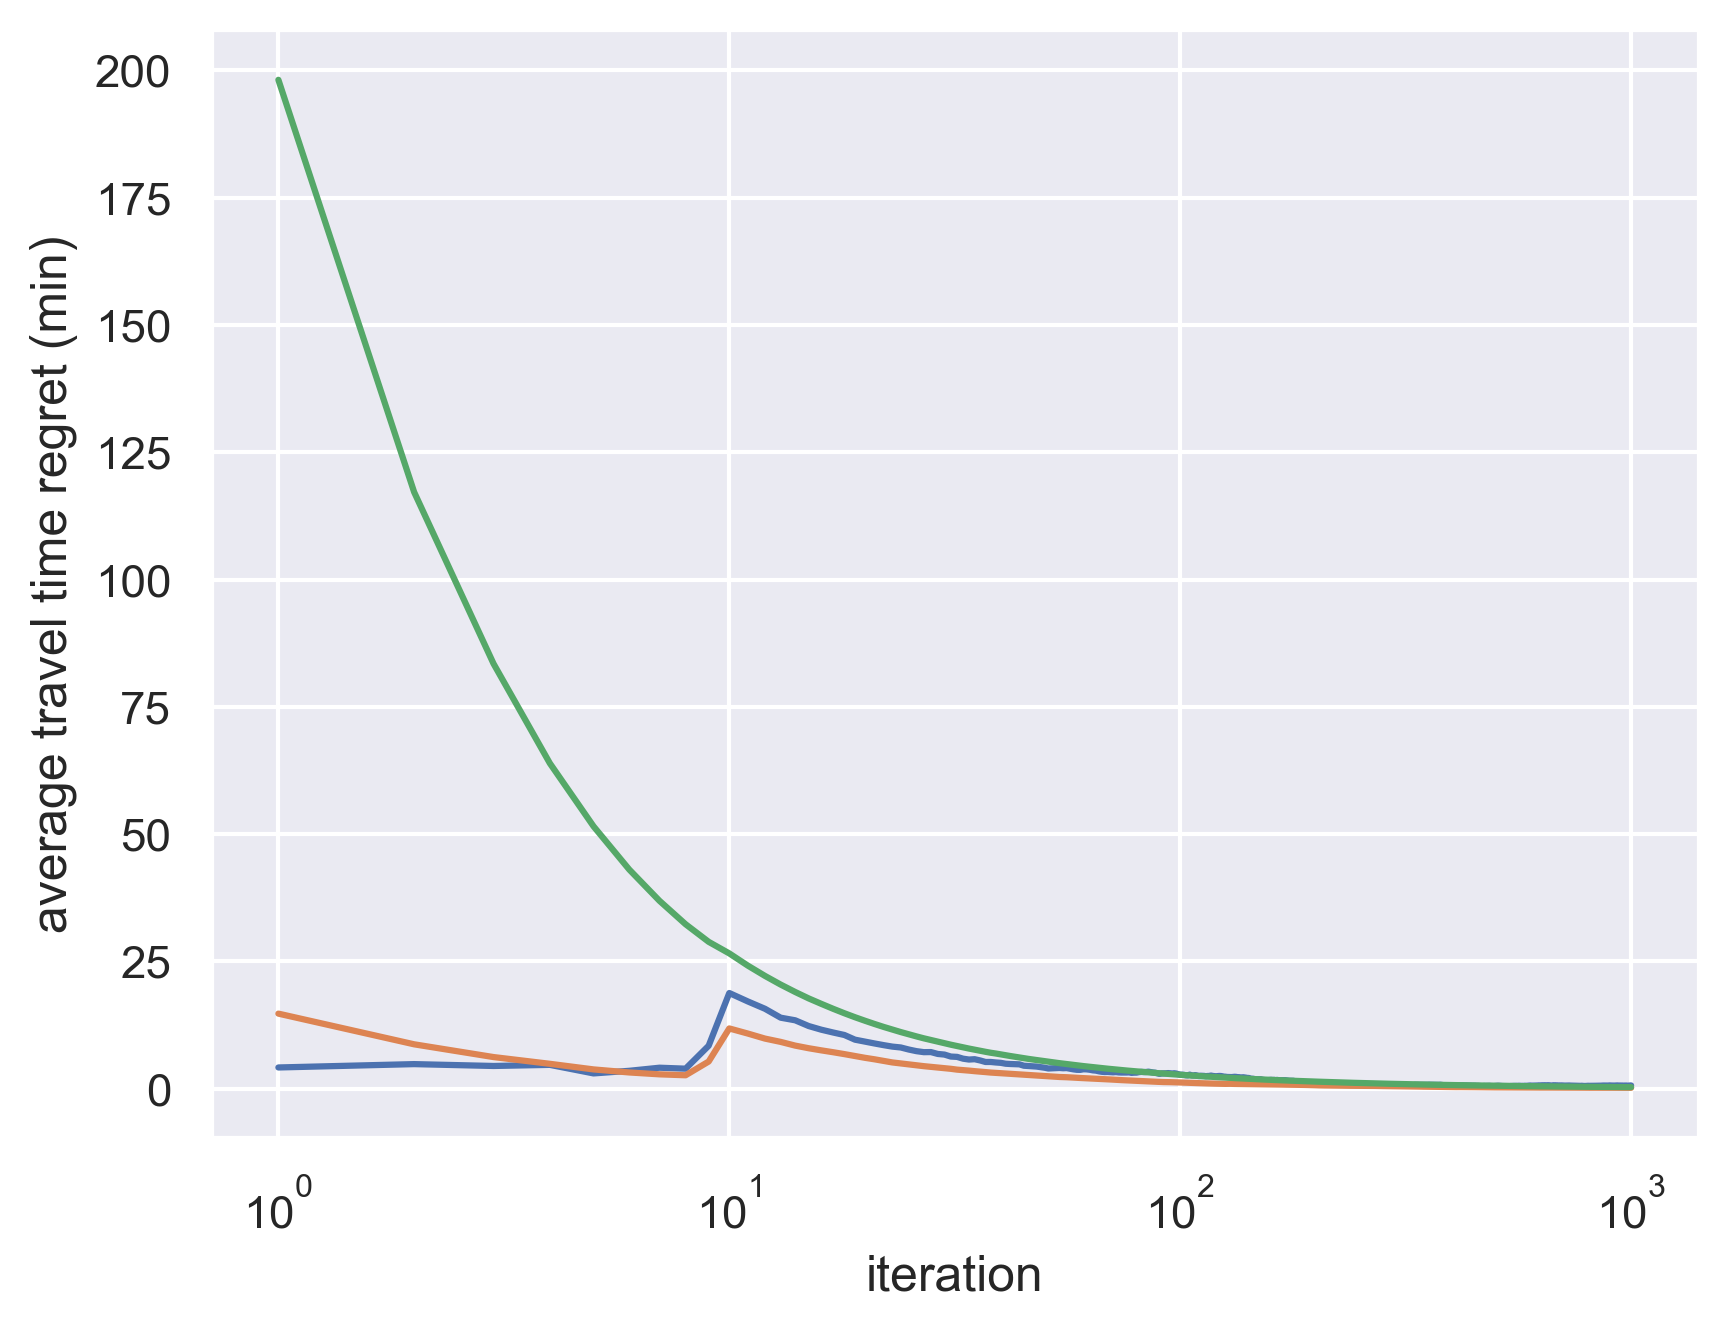

In [121]:
max_iter = 1000
for trust in trust_list:
    regret = (np.cumsum(travel_time[trust]) / (np.arange(max_iter) + 1) - opt_time[trust]) * 0.6
    ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret)
ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
# plt.yscale('log')
plt.xscale('log')

In [117]:
# test for three different trust rates
trust_list = [0.13, 0.48, 0.8]
actions_long, travel_time_long, total_time_bandit_long, pull_time_bandit_long, opt_time_long, sample_trust_list_long = {}, {}, {}, {}, {}, {}
for trust in trust_list:
    max_iter = 10000
    epsilon_greedy_opt.set_true_trust_rate(trust, 1e-3)
    actions_long[trust], travel_time_long[trust], total_time_bandit_long[trust], \
    pull_time_bandit_long[trust], opt_time_long[trust], sample_trust_list_long[trust] = epsilon_greedy_opt.run_ucb(max_iter)

At iteration 100, the cumulative average travel time is [ 916.13515194  925.98112105  917.81099337  917.47942451  924.76371586
  917.85933945  917.61474843  917.47232995  966.09100012 1031.37416364], and the regret is [ -0.19451679   9.65145232   1.48132464   1.14975578   8.43404713
   1.52967072   1.2850797    1.14266123  49.7613314  115.04449491]
At iteration 200, the cumulative average travel time is [ 916.08587179  925.98112105  917.81099337  917.47942451  924.76371586
  917.85933945  917.61474843  917.47232995  966.09100012 1031.37416364], and the regret is [ -0.24379693   9.65145232   1.48132464   1.14975578   8.43404713
   1.52967072   1.2850797    1.14266123  49.7613314  115.04449491]
At iteration 300, the cumulative average travel time is [ 916.31896222  925.98112105  917.81099337  917.47942451  924.76371586
  917.85933945  917.61474843  917.47232995  966.09100012 1031.37416364], and the regret is [-1.07065101e-02  9.65145232e+00  1.48132464e+00  1.14975578e+00
  8.43404713e+0

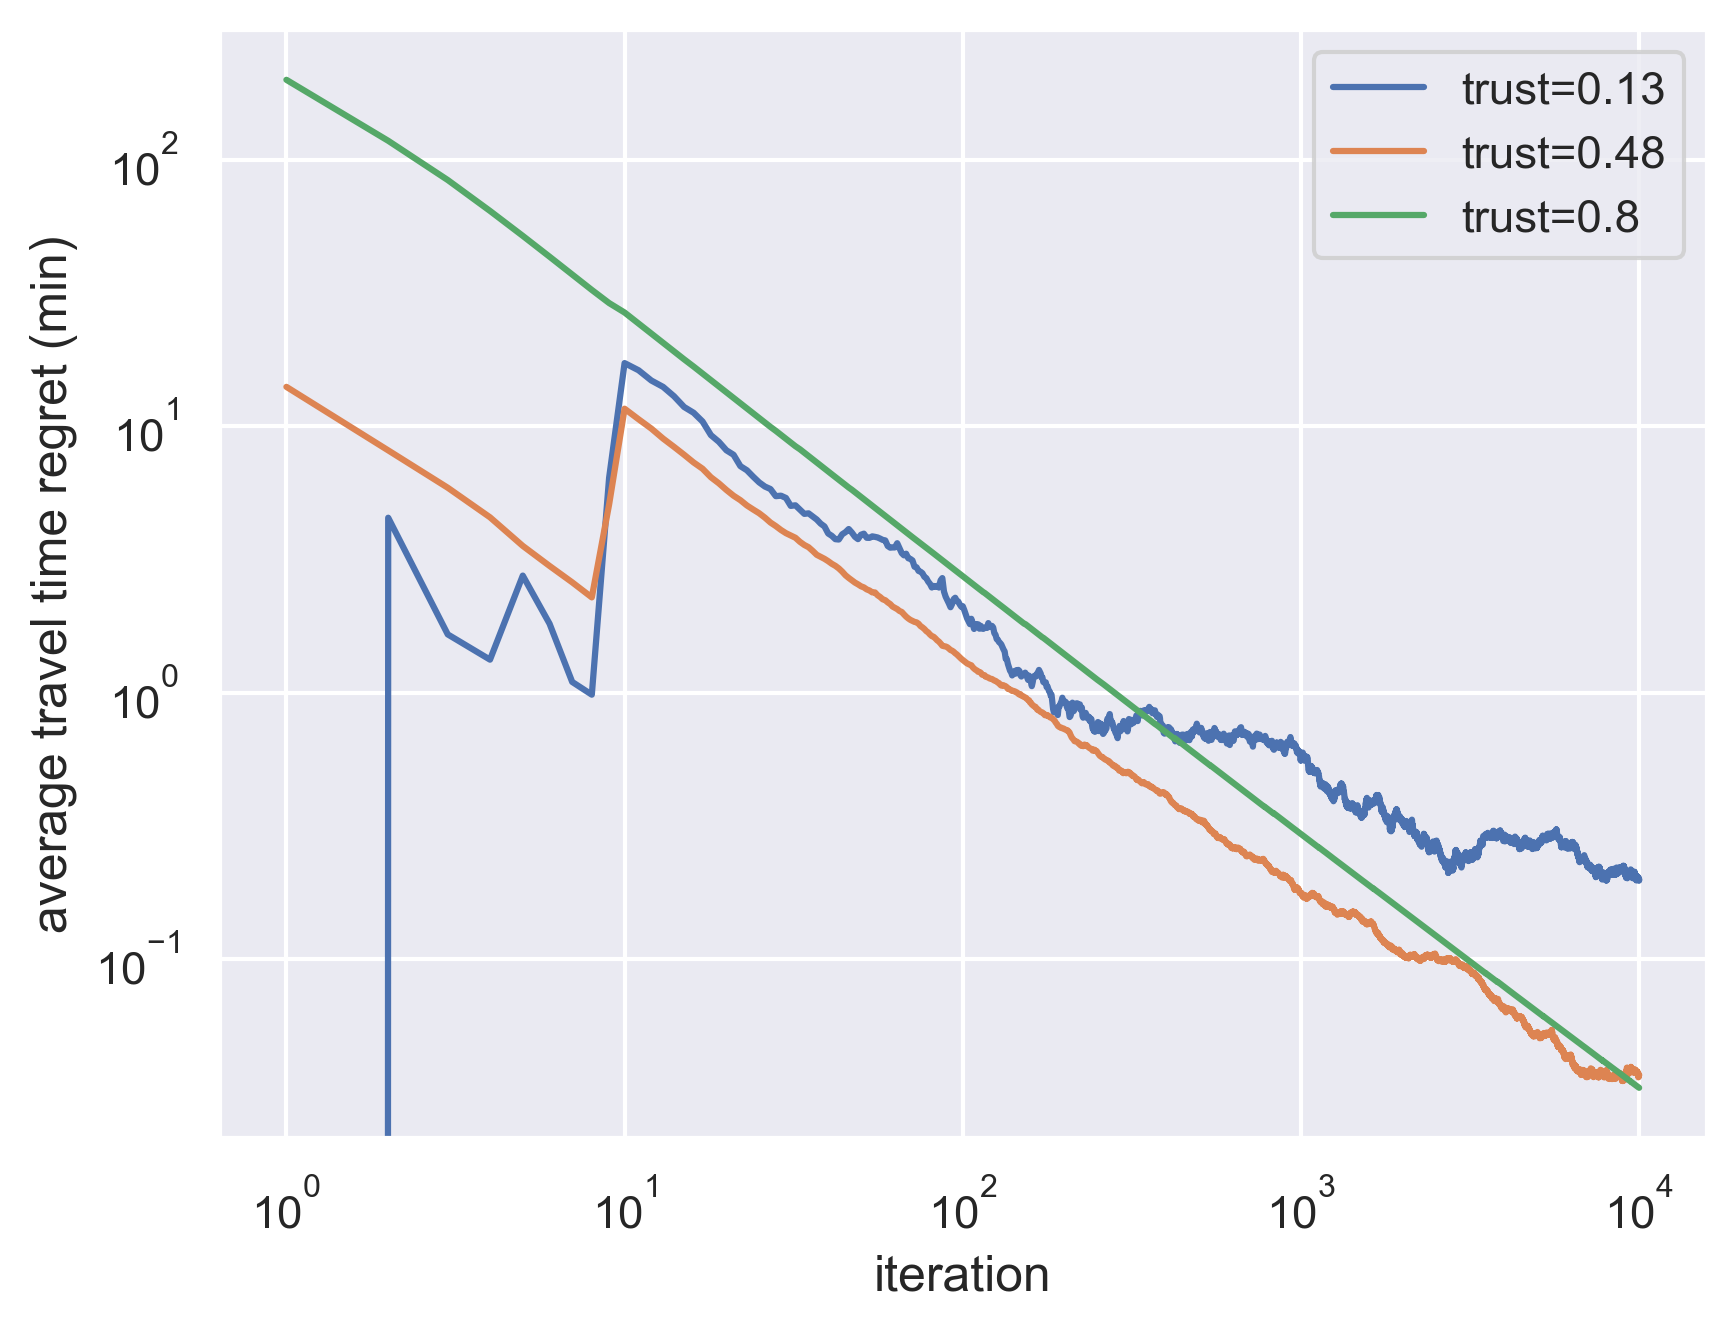

In [125]:
max_iter = 10000
for trust in trust_list:
    regret = (np.cumsum(travel_time_long[trust]) / (np.arange(max_iter) + 1) - opt_time_long[trust]) * 0.6
    ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret, label=f'trust={trust}')
ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
plt.yscale('log')
plt.xscale('log')
fig = ax.get_figure()
fig.savefig('bandit_figure/sioux_falls_regret_all_trust_ucb.png')

In [39]:
trust_list = [0.3, 0.8]
actions_long, travel_time_long, total_time_bandit_long, pull_time_bandit_long, opt_time_long, \
    sample_trust_list_long, time_bandit_diff, time_diff_iteration = {}, {}, {}, {}, {}, {}, {}, {}
for trust in trust_list:
    max_iter = 10000
    epsilon_greedy_opt.set_true_trust_rate(trust, 1e-3)
    actions_long[trust], travel_time_long[trust], total_time_bandit_long[trust], \
        pull_time_bandit_long[trust], opt_time_long[trust], sample_trust_list_long[trust], \
            time_bandit_diff[trust], time_diff_iteration[trust] = epsilon_greedy_opt.run_ucb(max_iter, beta=1, reward='learn')

At iteration 100, the cumulative average travel time is 314.78099995028407, and the regret is 2.03637066741519
At iteration 200, the cumulative average travel time is 313.72772631933, and the regret is 0.9830970364610948
At iteration 300, the cumulative average travel time is 313.3713056594398, and the regret is 0.6266763765709583
At iteration 400, the cumulative average travel time is 313.26805272772384, and the regret is 0.5234234448549386
At iteration 500, the cumulative average travel time is 313.22988891201146, and the regret is 0.4852596291425925
At iteration 600, the cumulative average travel time is 313.19054862293785, and the regret is 0.44591934006898554
At iteration 700, the cumulative average travel time is 313.122218794224, and the regret is 0.3775895113551087
At iteration 800, the cumulative average travel time is 313.1381598087468, and the regret is 0.3935305258779408
At iteration 900, the cumulative average travel time is 313.05435103813204, and the regret is 0.30972175

In [42]:
trust_list = [0.3, 0.8]
actions_final, travel_time_final, total_time_bandit_final, pull_time_bandit_final, opt_time_final, sample_trust_list_final = {}, {}, {}, {}, {}, {}
for trust in trust_list:
    max_iter = 10000
    epsilon_greedy_opt.set_true_trust_rate(trust, 1e-3)
    actions_final[trust], travel_time_final[trust], total_time_bandit_final[trust], \
    pull_time_bandit_final[trust], opt_time_final[trust], sample_trust_list_final[trust], _, _ \
        = epsilon_greedy_opt.run_ucb(max_iter, beta=1, reward='final')

At iteration 100, the cumulative average travel time is 314.6865597303294, and the regret is 1.9419304474605268
At iteration 200, the cumulative average travel time is 313.8535104435492, and the regret is 1.1088811606803346
At iteration 300, the cumulative average travel time is 313.3669065965429, and the regret is 0.6222773136739989
At iteration 400, the cumulative average travel time is 313.29392089671796, and the regret is 0.5492916138490954
At iteration 500, the cumulative average travel time is 313.1213602908779, and the regret is 0.3767310080089828
At iteration 600, the cumulative average travel time is 313.06430213972016, and the regret is 0.3196728568512981
At iteration 700, the cumulative average travel time is 313.03335952288904, and the regret is 0.2887302400201861
At iteration 800, the cumulative average travel time is 312.99700110588003, and the regret is 0.25237182301113986
At iteration 900, the cumulative average travel time is 313.01420186872355, and the regret is 0.269

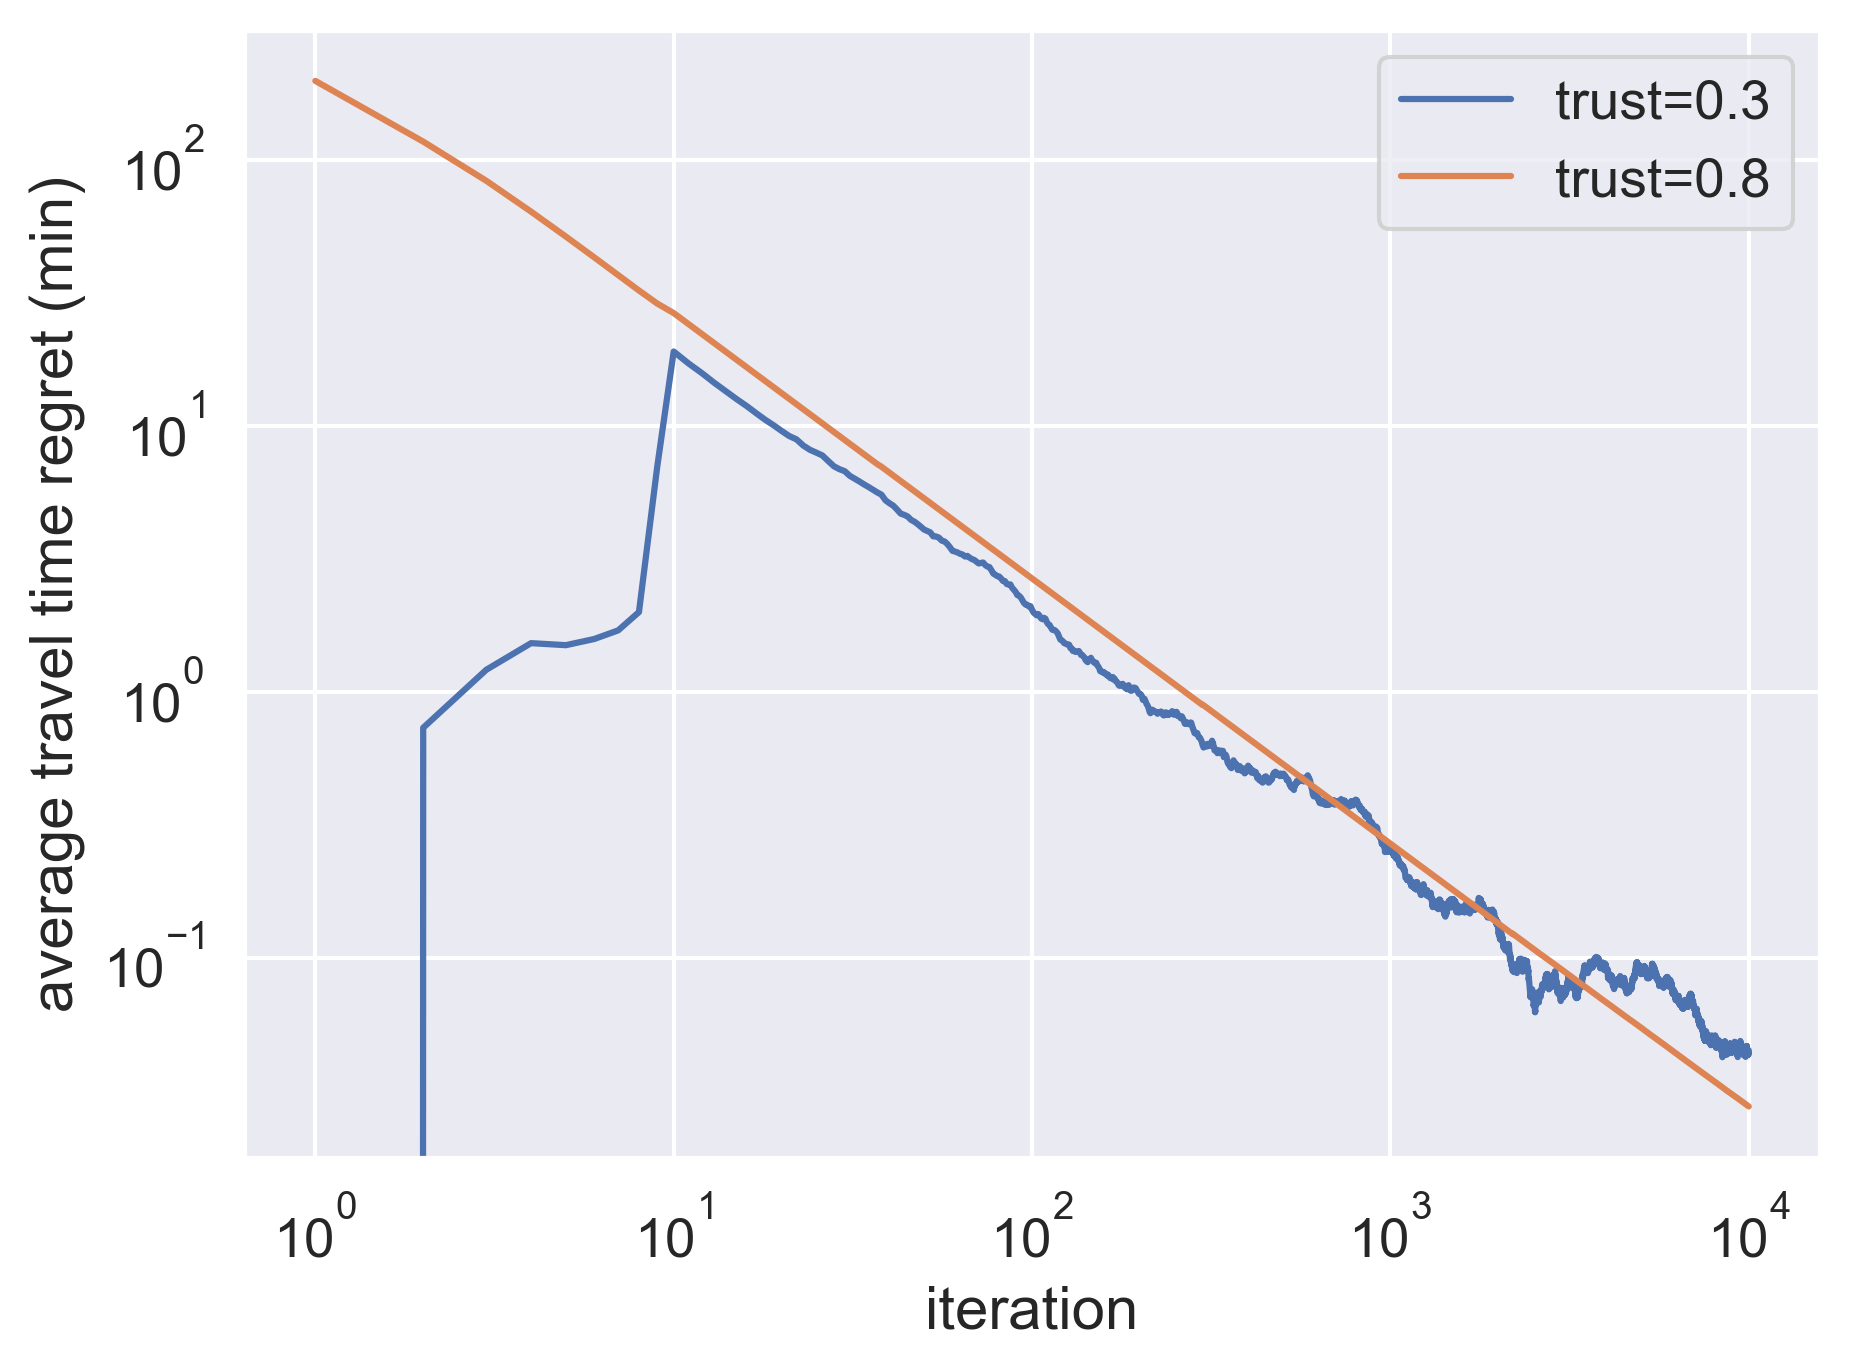

In [41]:
for trust in [0.3, 0.8]:
    regret = (np.cumsum(travel_time_long[trust]) / (np.arange(max_iter) + 1) - opt_time_long[trust]) * 0.6
    ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret, label=f'trust={trust}')
# set sns font scale
sns.set(font_scale=1.2)
ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
plt.yscale('log')
plt.xscale('log')
fig = ax.get_figure()
fig.tight_layout()
# fig.savefig('bandit_figure/sioux_falls_regret_two_trust_ucb_test_rewardlearn.png')

0.008558692421991084

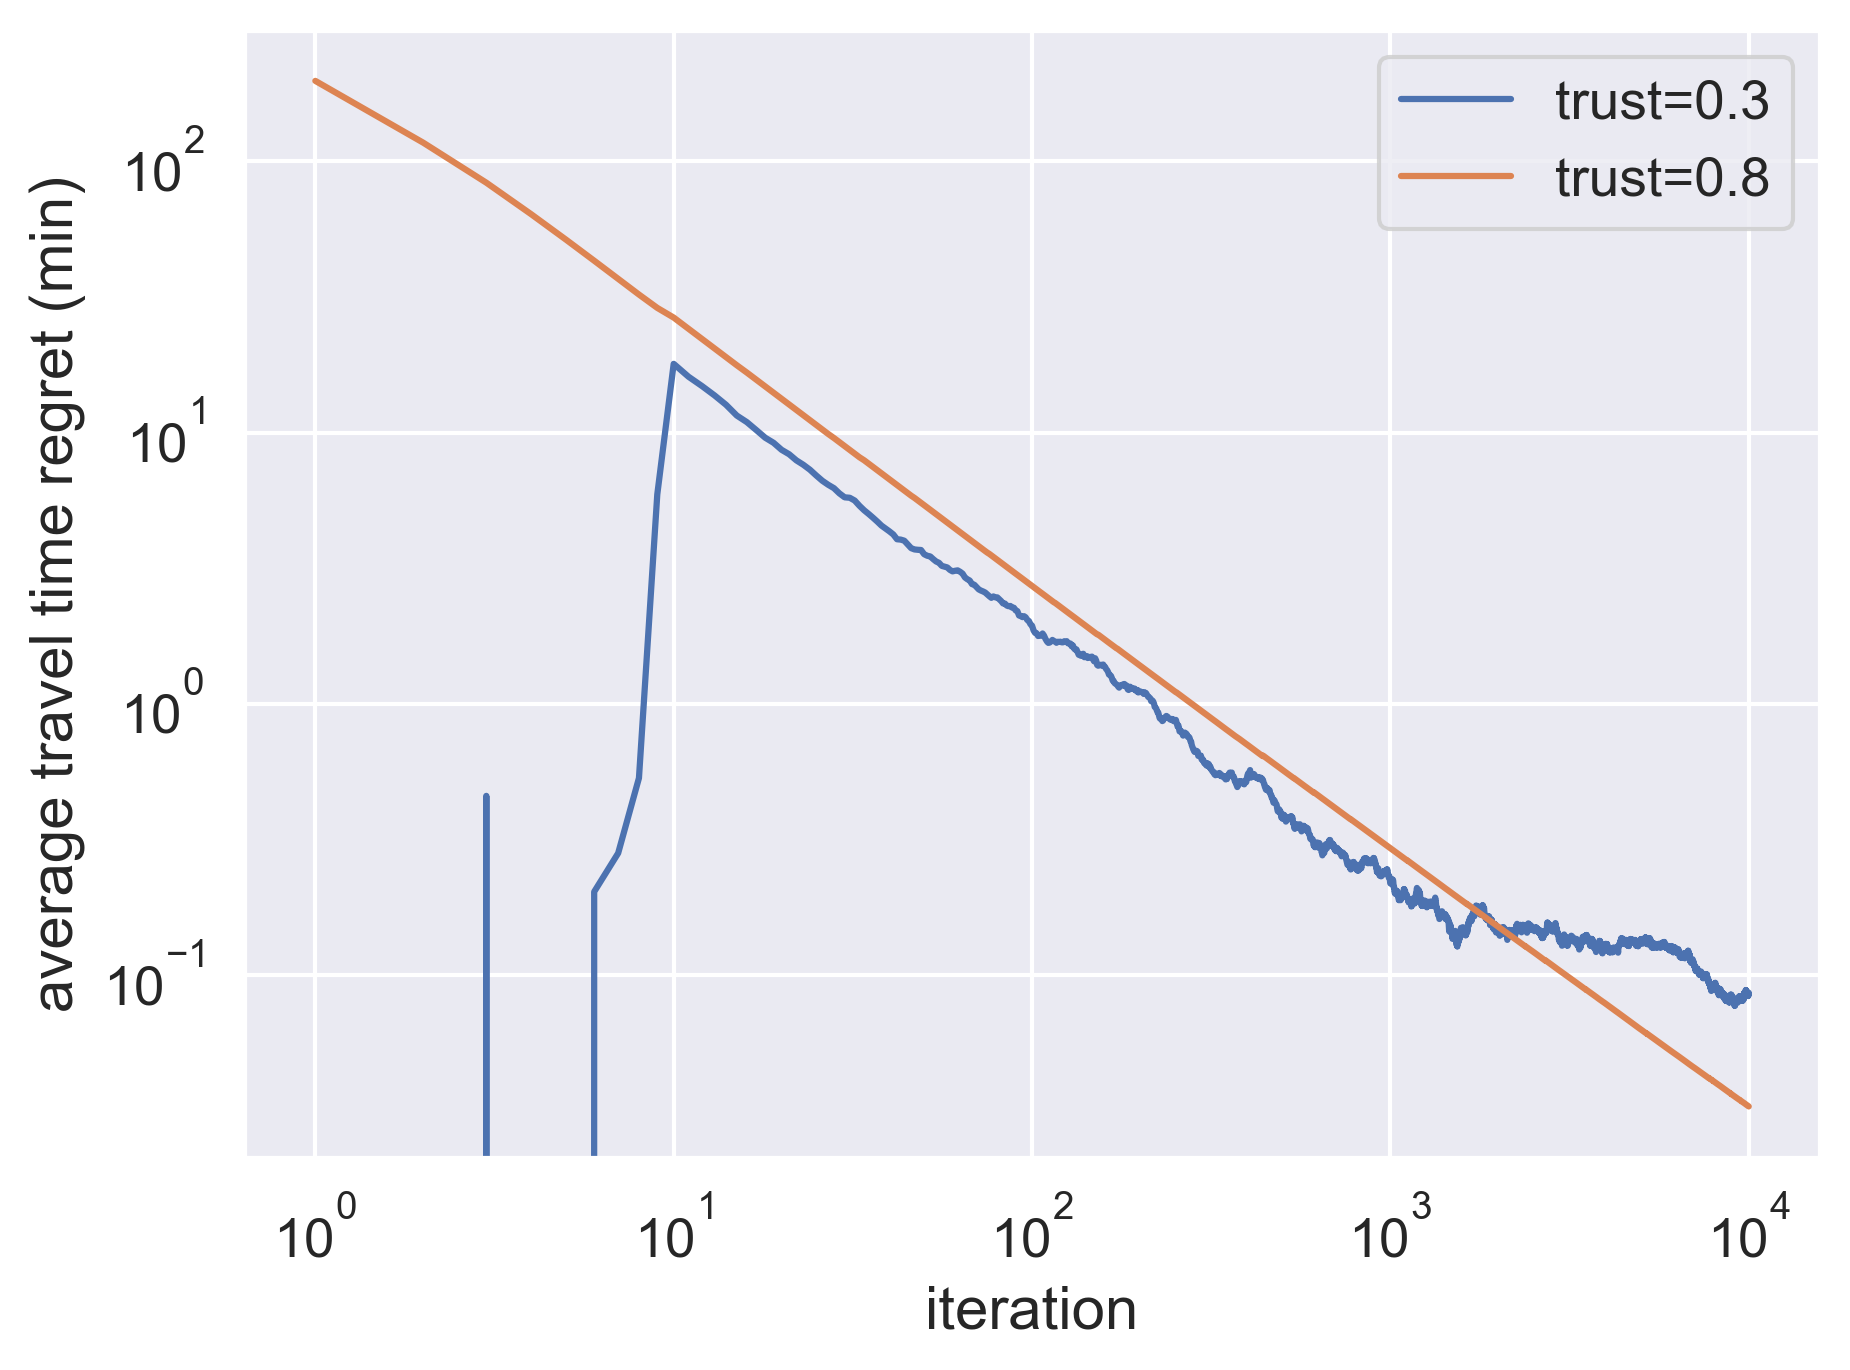

In [43]:
for trust in [0.3, 0.8]:
    regret = (np.cumsum(travel_time_final[trust]) / (np.arange(max_iter) + 1) - opt_time_final[trust]) * 0.6
    ax = sns.lineplot(x=np.arange(max_iter) + 1, y=regret, label=f'trust={trust}')
# set sns font scale
sns.set(font_scale=1.2)
ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
plt.yscale('log')
plt.xscale('log')
fig = ax.get_figure()
fig.tight_layout()

trust * (1-trust) / sum(demand.values())

In [125]:
def test_bandit_single_trust(trust, reward_way='learn', num_runs=10, std=1e-3, num_ite=10000, opt=None):
    # initialize a dataframe to store the results
    all_regret = []
    all_results = []
    for i in range(num_runs):
        # run bandit
        max_iter = int(num_ite)
        epsilon_greedy_opt.set_true_trust_rate(trust, std)
        res = epsilon_greedy_opt.run_ucb(max_iter, beta=1, reward=reward_way)
        # calculate regret
        if opt is None:
            opt = res['opt_time']
        regret = (np.cumsum(res['travel_time']) / (np.arange(max_iter) + 1) - opt) * 0.6
        all_regret.append(regret)
        all_results.append(res)
    return all_regret, all_results

In [ ]:
all_regret_final_adjust, all_results_final_adjust = test_bandit_single_trust(0.3, reward_way='final', num_runs=10,
                                                                             std=1e-2, num_ite=1e4, opt=522.3194864331622)

At iteration 1000, the cumulative average travel time is 314.8320301462948, and the regret is 2.0874008634257506
At iteration 2000, the cumulative average travel time is 314.8523618557405, and the regret is 2.1077325728714187
At iteration 3000, the cumulative average travel time is 314.47661972380973, and the regret is 1.731990440940649
At iteration 4000, the cumulative average travel time is 314.10549547943003, and the regret is 1.3608661965609372
At iteration 5000, the cumulative average travel time is 314.1174608114458, and the regret is 1.3728315285767394
At iteration 6000, the cumulative average travel time is 314.2663283409692, and the regret is 1.5216990581001255
At iteration 7000, the cumulative average travel time is 314.2502145241262, and the regret is 1.5055852412570856
At iteration 8000, the cumulative average travel time is 314.4684318610466, and the regret is 1.7238025781775377
At iteration 9000, the cumulative average travel time is 314.5544686125641, and the regret is 1

In [126]:
all_regret_final_normal, all_results_final_normal = test_bandit_single_trust(0.3, reward_way='final', num_runs=10,
                                                                             std=1e-2, num_ite=1e4, opt=522.3194864331622)

At iteration 1000, the cumulative average travel time is 316.21770672437793, and the regret is 3.4730774415088264
At iteration 2000, the cumulative average travel time is 315.4700956608995, and the regret is 2.72546637803041
At iteration 3000, the cumulative average travel time is 315.00473478242026, and the regret is 2.2601054995511958
At iteration 4000, the cumulative average travel time is 315.0103692101786, and the regret is 2.265739927309528
At iteration 5000, the cumulative average travel time is 315.0714060360979, and the regret is 2.326776753228819
At iteration 6000, the cumulative average travel time is 314.8636641182372, and the regret is 2.119034835368075
At iteration 7000, the cumulative average travel time is 314.88750539895204, and the regret is 2.142876116082948
At iteration 8000, the cumulative average travel time is 315.0452451304382, and the regret is 2.300615847569111
At iteration 9000, the cumulative average travel time is 314.996474596413, and the regret is 2.25184

In [118]:
all_regret_final_normal[0].shape

(10000,)

In [54]:
all_regret_final, all_results_final = test_bandit_single_trust(0.8, reward_way='final', num_runs=10)

At iteration 1000, the cumulative average travel time is 9.035492787991533, and the regret is 0.29544449336456996
At iteration 2000, the cumulative average travel time is 8.891804660203723, and the regret is 0.15175636557675956
At iteration 3000, the cumulative average travel time is 8.842982456214662, and the regret is 0.10293416158769837
At iteration 4000, the cumulative average travel time is 8.818620469410282, and the regret is 0.07857217478331897
At iteration 5000, the cumulative average travel time is 8.803458280178488, and the regret is 0.06340998555152452
At iteration 6000, the cumulative average travel time is 8.793375529431623, and the regret is 0.053327234804659084
At iteration 7000, the cumulative average travel time is 8.786061948554028, and the regret is 0.04601365392706391
At iteration 8000, the cumulative average travel time is 8.780691903908517, and the regret is 0.04064360928155288
At iteration 9000, the cumulative average travel time is 8.776394410208427, and the reg

In [108]:
def draw_figure_runs(all_regret_learn, all_regret_final):
    for all_regret, label in zip([all_regret_learn, all_regret_final], ['diff', 'total']):
        regret_df = pd.DataFrame(all_regret).T
        regret_df['iteration'] = regret_df.index + 1
        # melt with iteration
        regret_df_melt = pd.melt(regret_df, id_vars=['iteration'], value_vars=regret_df.columns[:-1],
                                 value_name='regret')
        # draw figure
        ax = sns.lineplot(x='iteration', y='regret', data=regret_df_melt, label=label, errorbar='sd')
    # set sns font scale
    sns.set(font_scale=1.2)
    ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
    plt.yscale('log')
    plt.xscale('log')
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

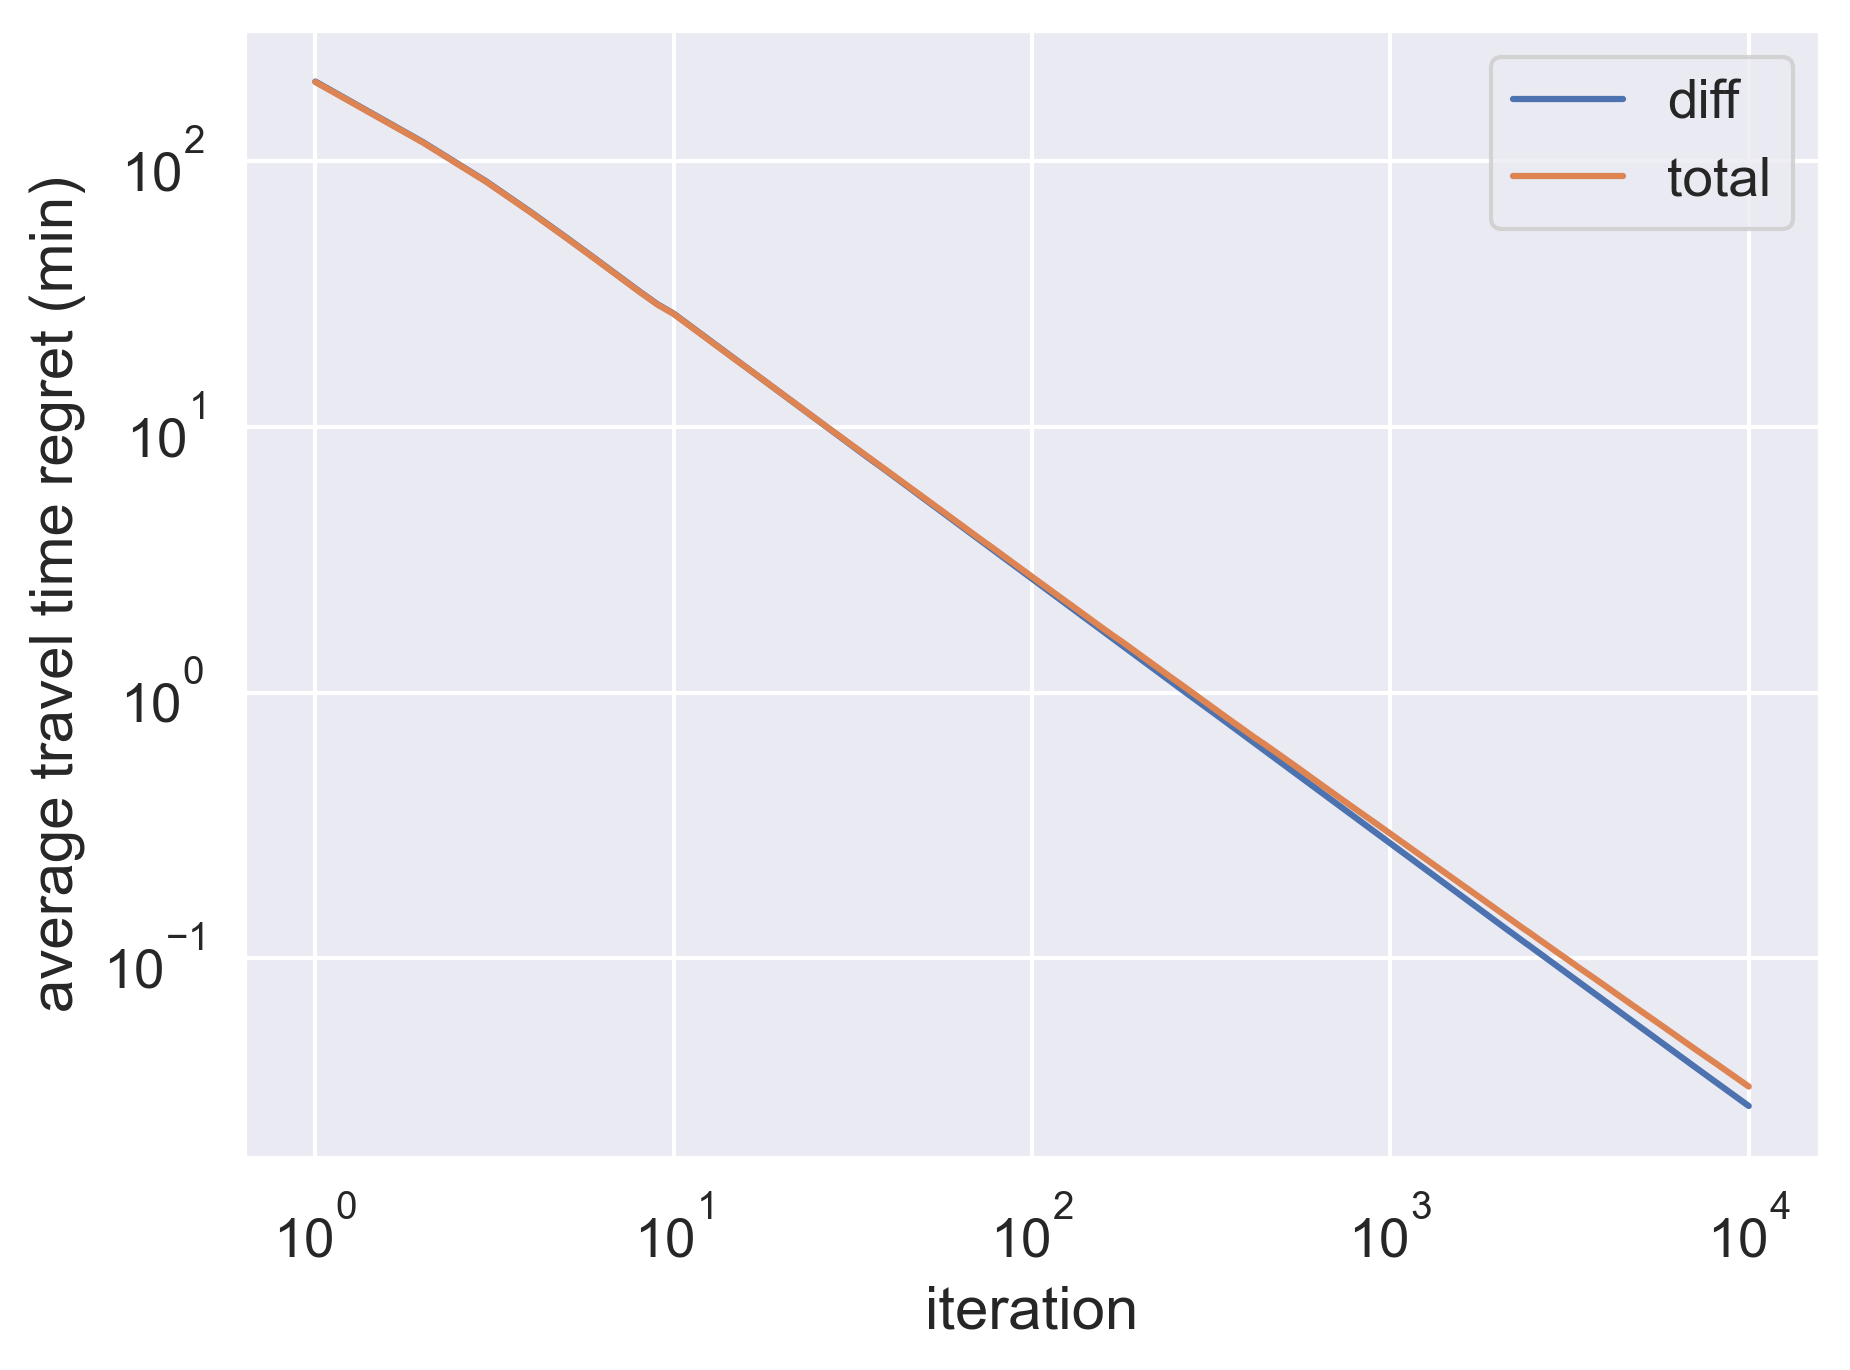

In [58]:
fig_all_0p8 = draw_figure_runs(all_regret, all_regret_final)

At iteration 1000, the cumulative average travel time is 313.0010070112675, and the regret is 0.25637772839861556
At iteration 2000, the cumulative average travel time is 312.90885045112054, and the regret is 0.1642211682516745
At iteration 3000, the cumulative average travel time is 312.85073011729526, and the regret is 0.1061008344263655
At iteration 4000, the cumulative average travel time is 312.8362431758782, and the regret is 0.09161389300932114
At iteration 5000, the cumulative average travel time is 312.82142320426476, and the regret is 0.07679392139589254
At iteration 6000, the cumulative average travel time is 312.81896444327214, and the regret is 0.07433516040325684
At iteration 7000, the cumulative average travel time is 312.80316113385516, and the regret is 0.05853185098626454
At iteration 8000, the cumulative average travel time is 312.7975330367081, and the regret is 0.0529037538392231
At iteration 9000, the cumulative average travel time is 312.7831747798756, and the re

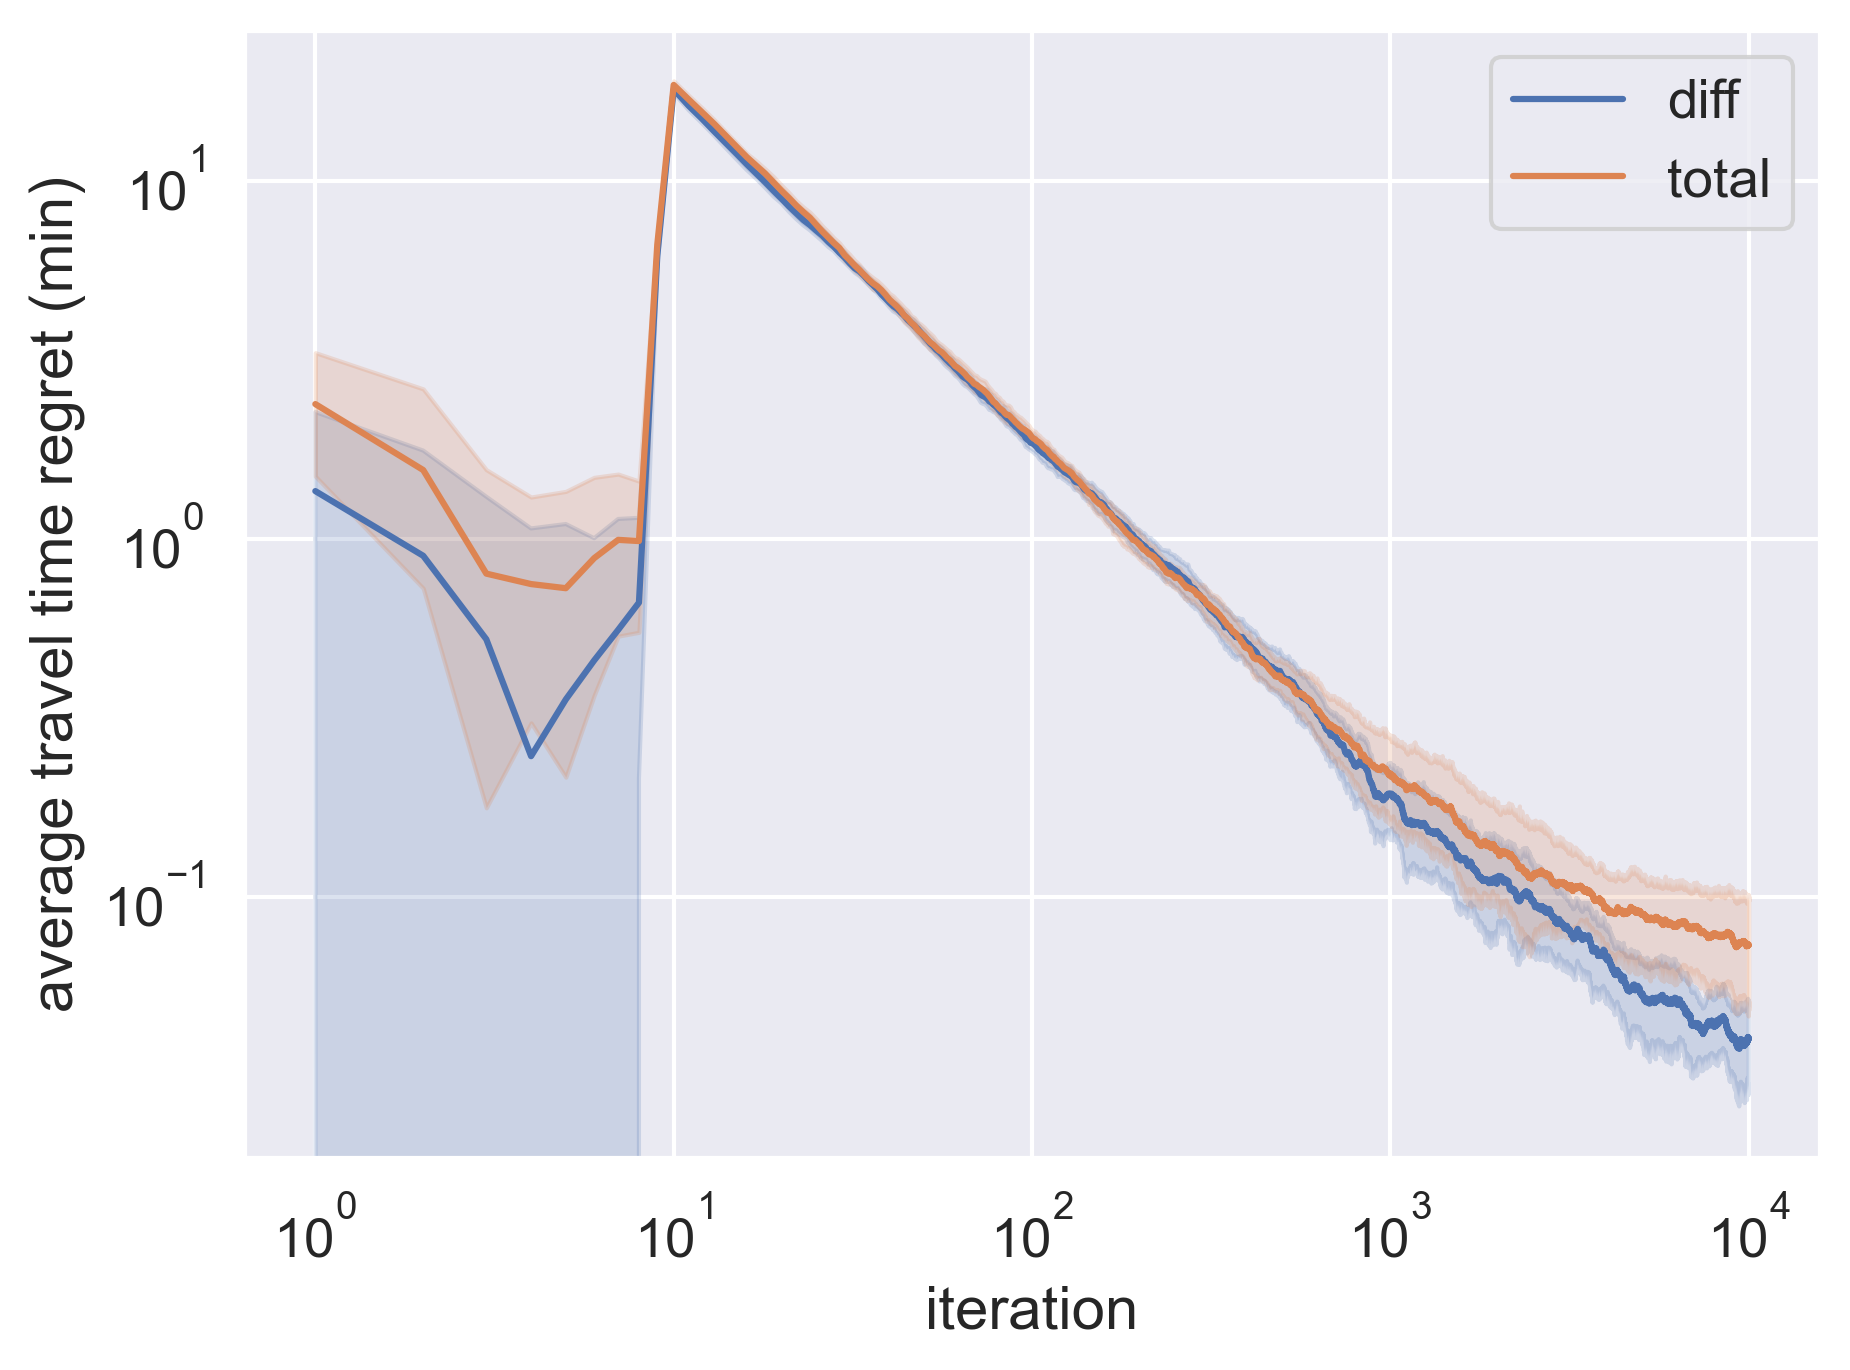

In [59]:
all_regret_diff_0p3, all_results_diff_0p3 = test_bandit_single_trust(0.3, reward_way='learn', num_runs=10)
all_regret_final_0p3, all_results_final_0p3 = test_bandit_single_trust(0.3, reward_way='final', num_runs=10)
fig_all_0p3 = draw_figure_runs(all_regret_diff_0p3, all_regret_final_0p3)

In [60]:
fig_all_0p8.savefig('bandit_figure/sioux_falls_regret_trust_0p8_ucb_two_reward.png')
fig_all_0p3.savefig('bandit_figure/sioux_falls_regret_trust_0p3_ucb_two_reward.png')

In [ ]:
regret_df = pd.DataFrame(all_regret).T
regret_df['iteration'] = regret_df.index + 1
regret_df_melt = pd.melt(regret_df, id_vars=['iteration'], value_vars=regret_df.columns[:-1])
regret_df_melt[regret_df_melt['iteration'] == 1]

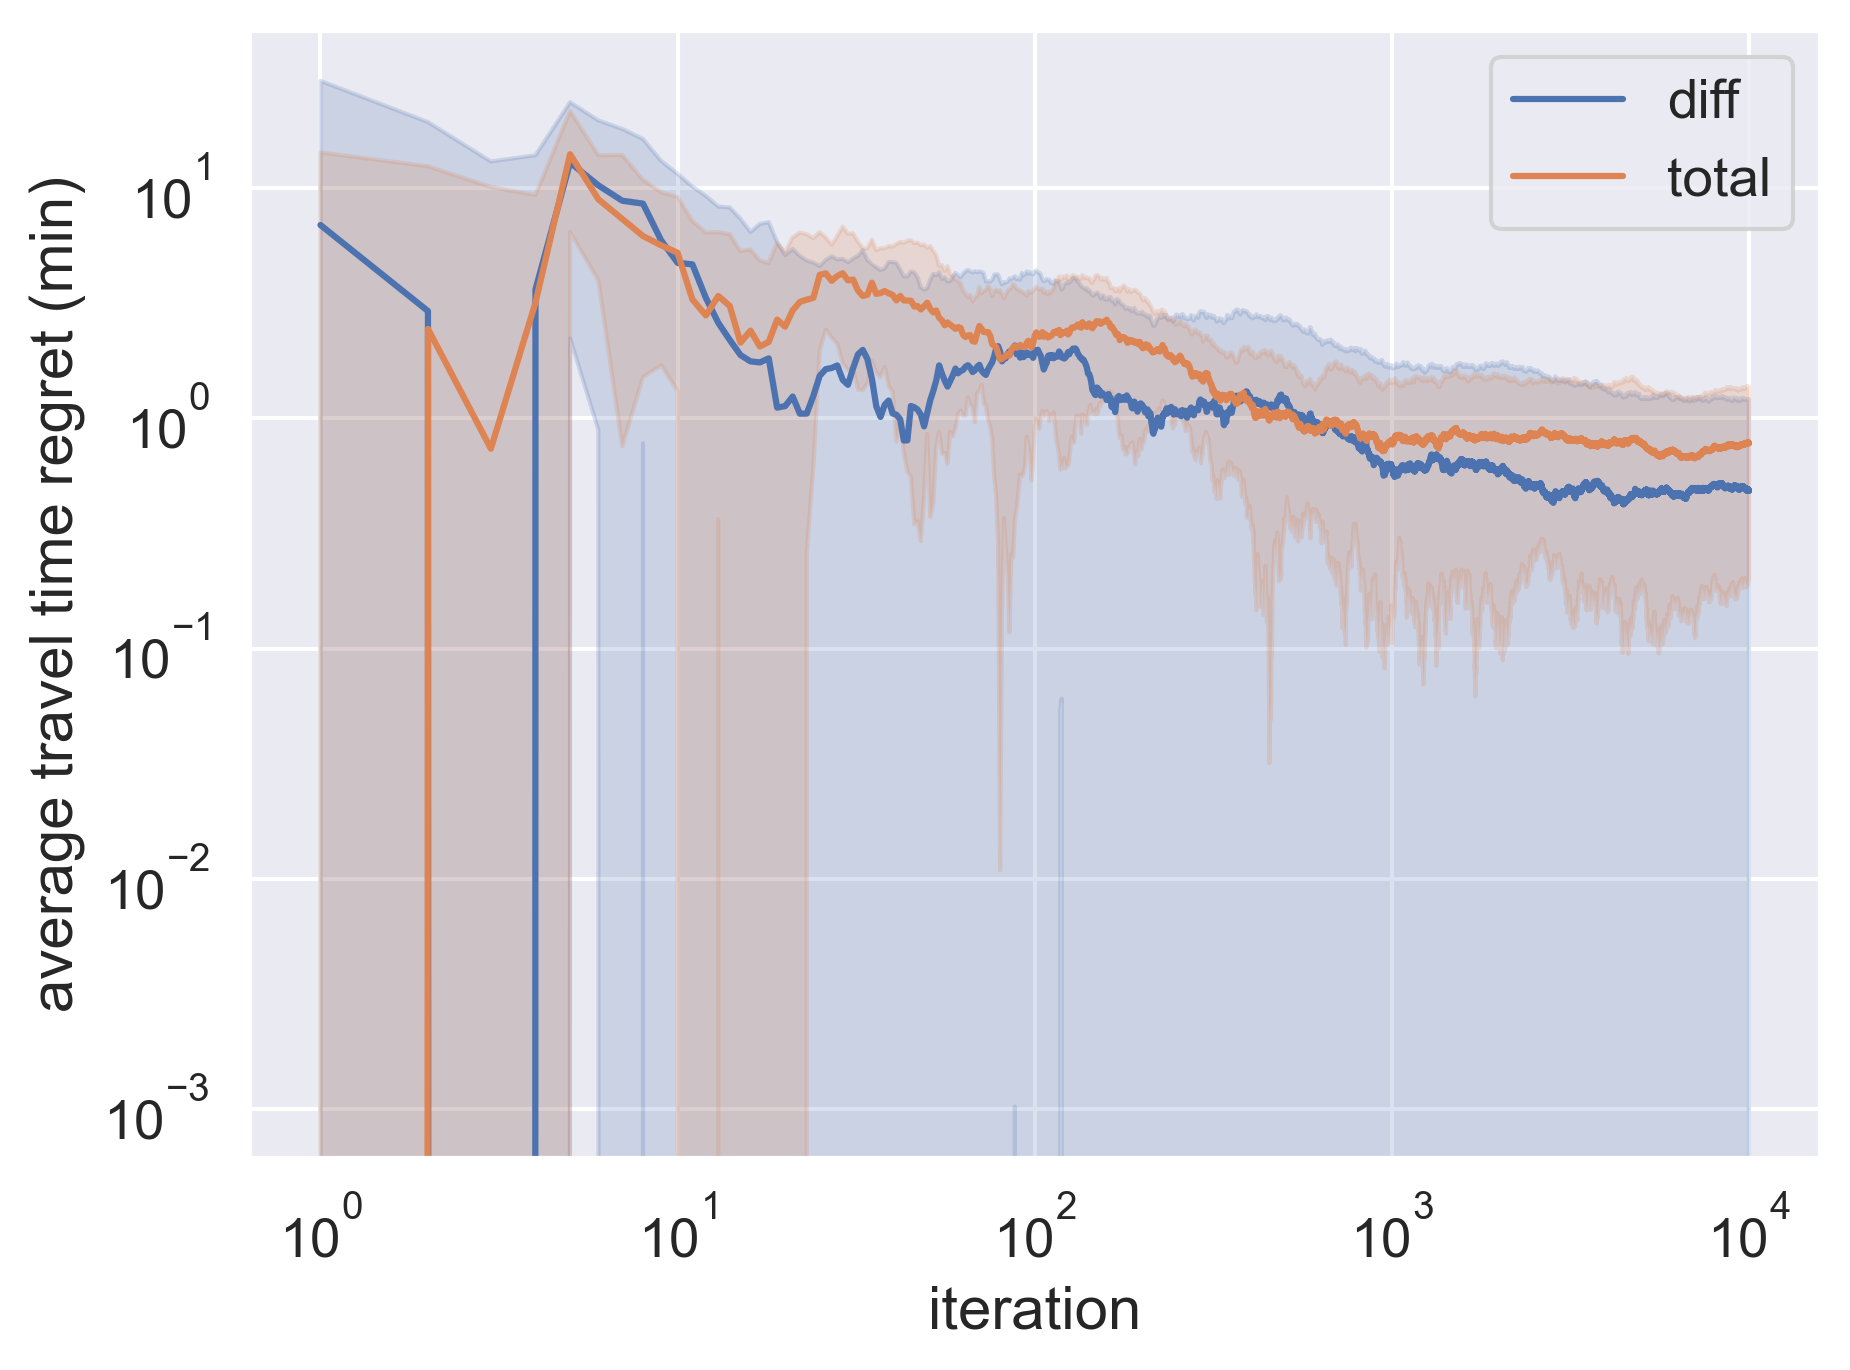

In [119]:
fig = draw_figure_runs(all_regret_final_adjust, all_regret_final_normal)

In [121]:
all_results_final_normal[0]['total_time_bandit'] / all_results_final_normal[0]['pull_time_bandit']

array([524.75196158, 549.51945835, 538.26880088, 528.82741855,
       680.92820696])

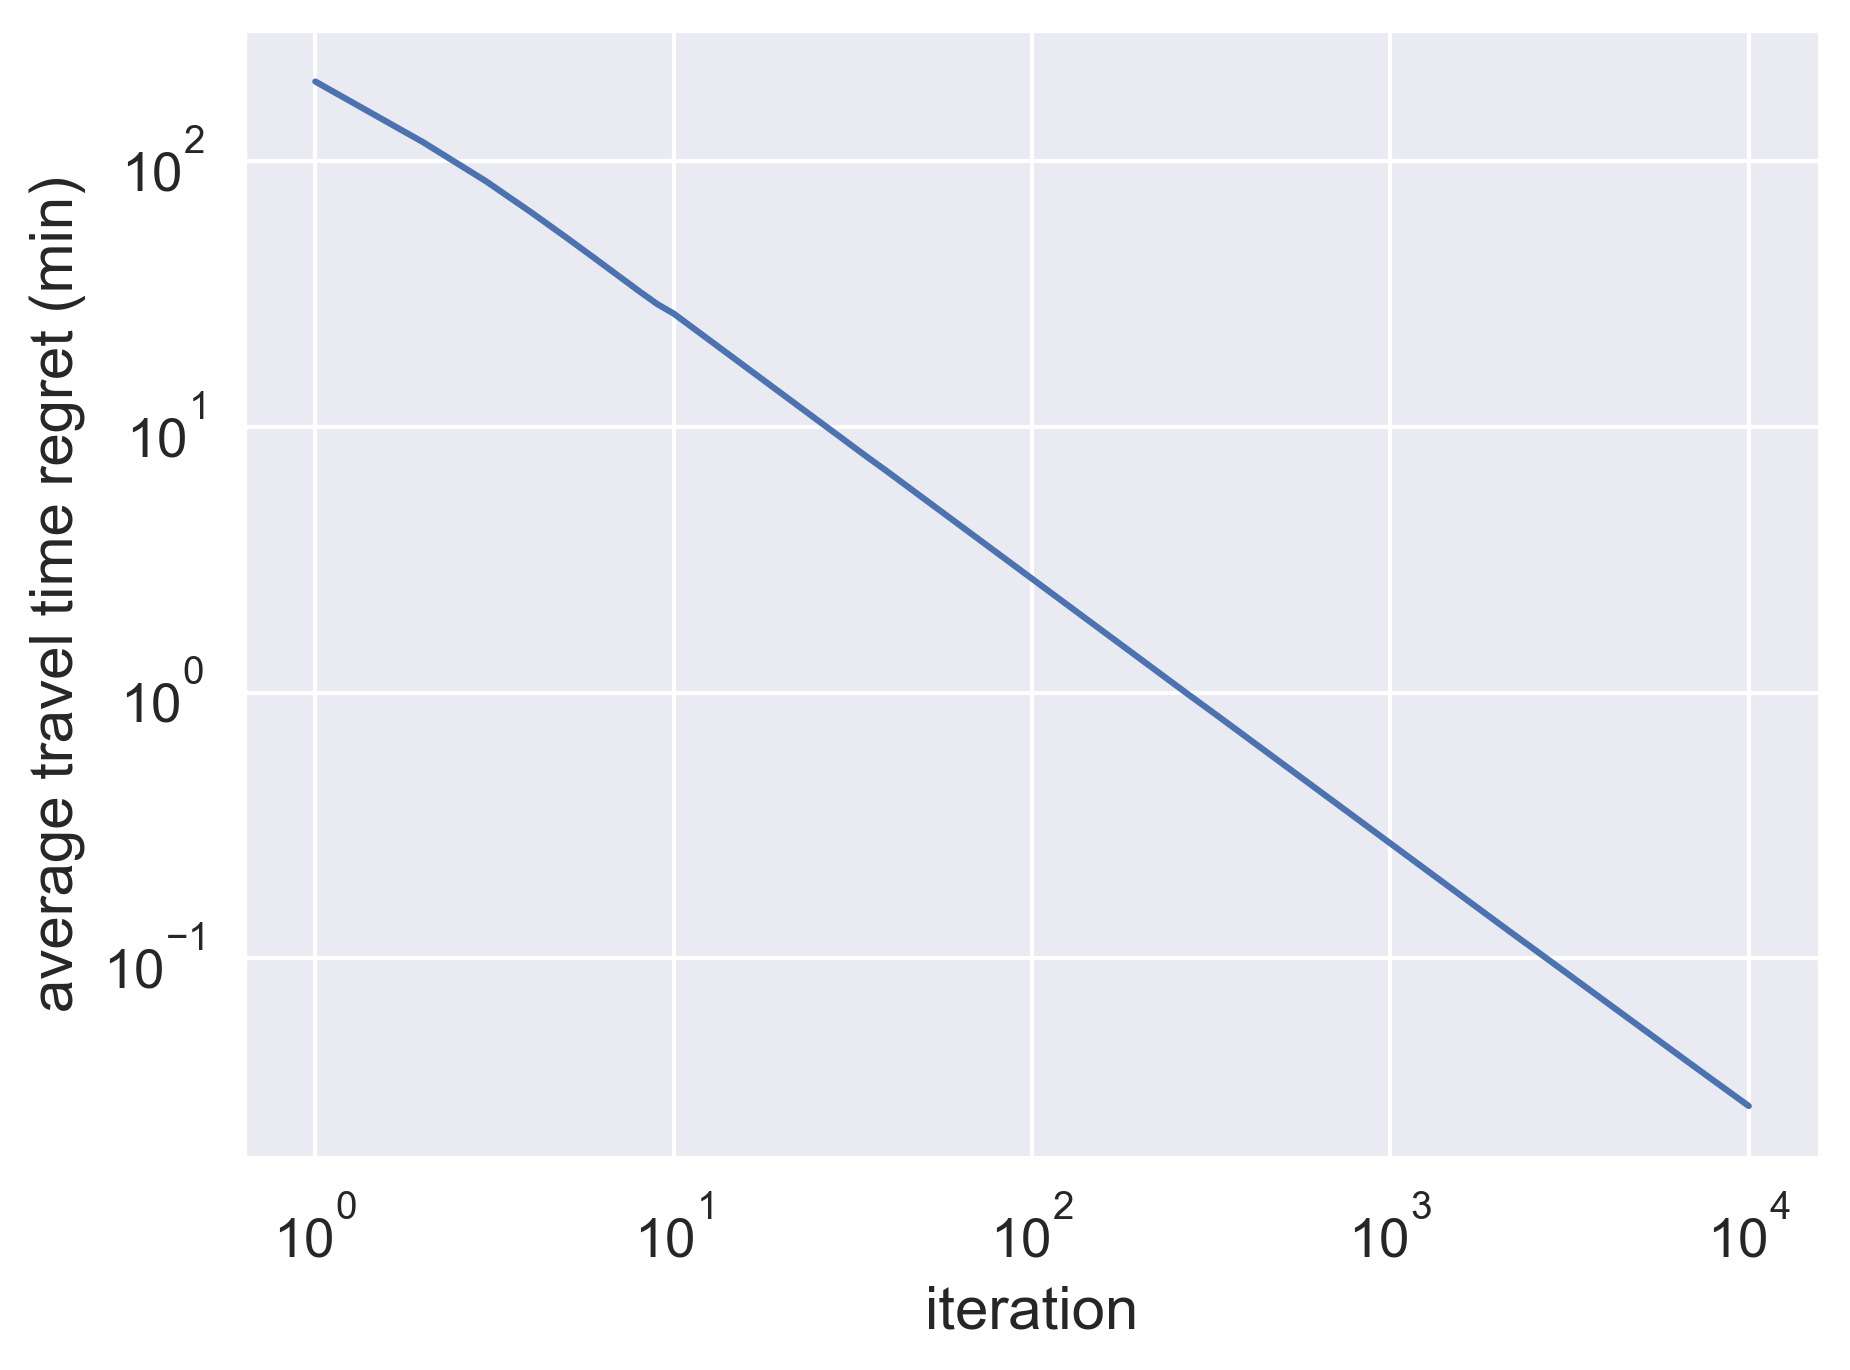

In [53]:
fig_2 = draw_figure_runs(all_regret)


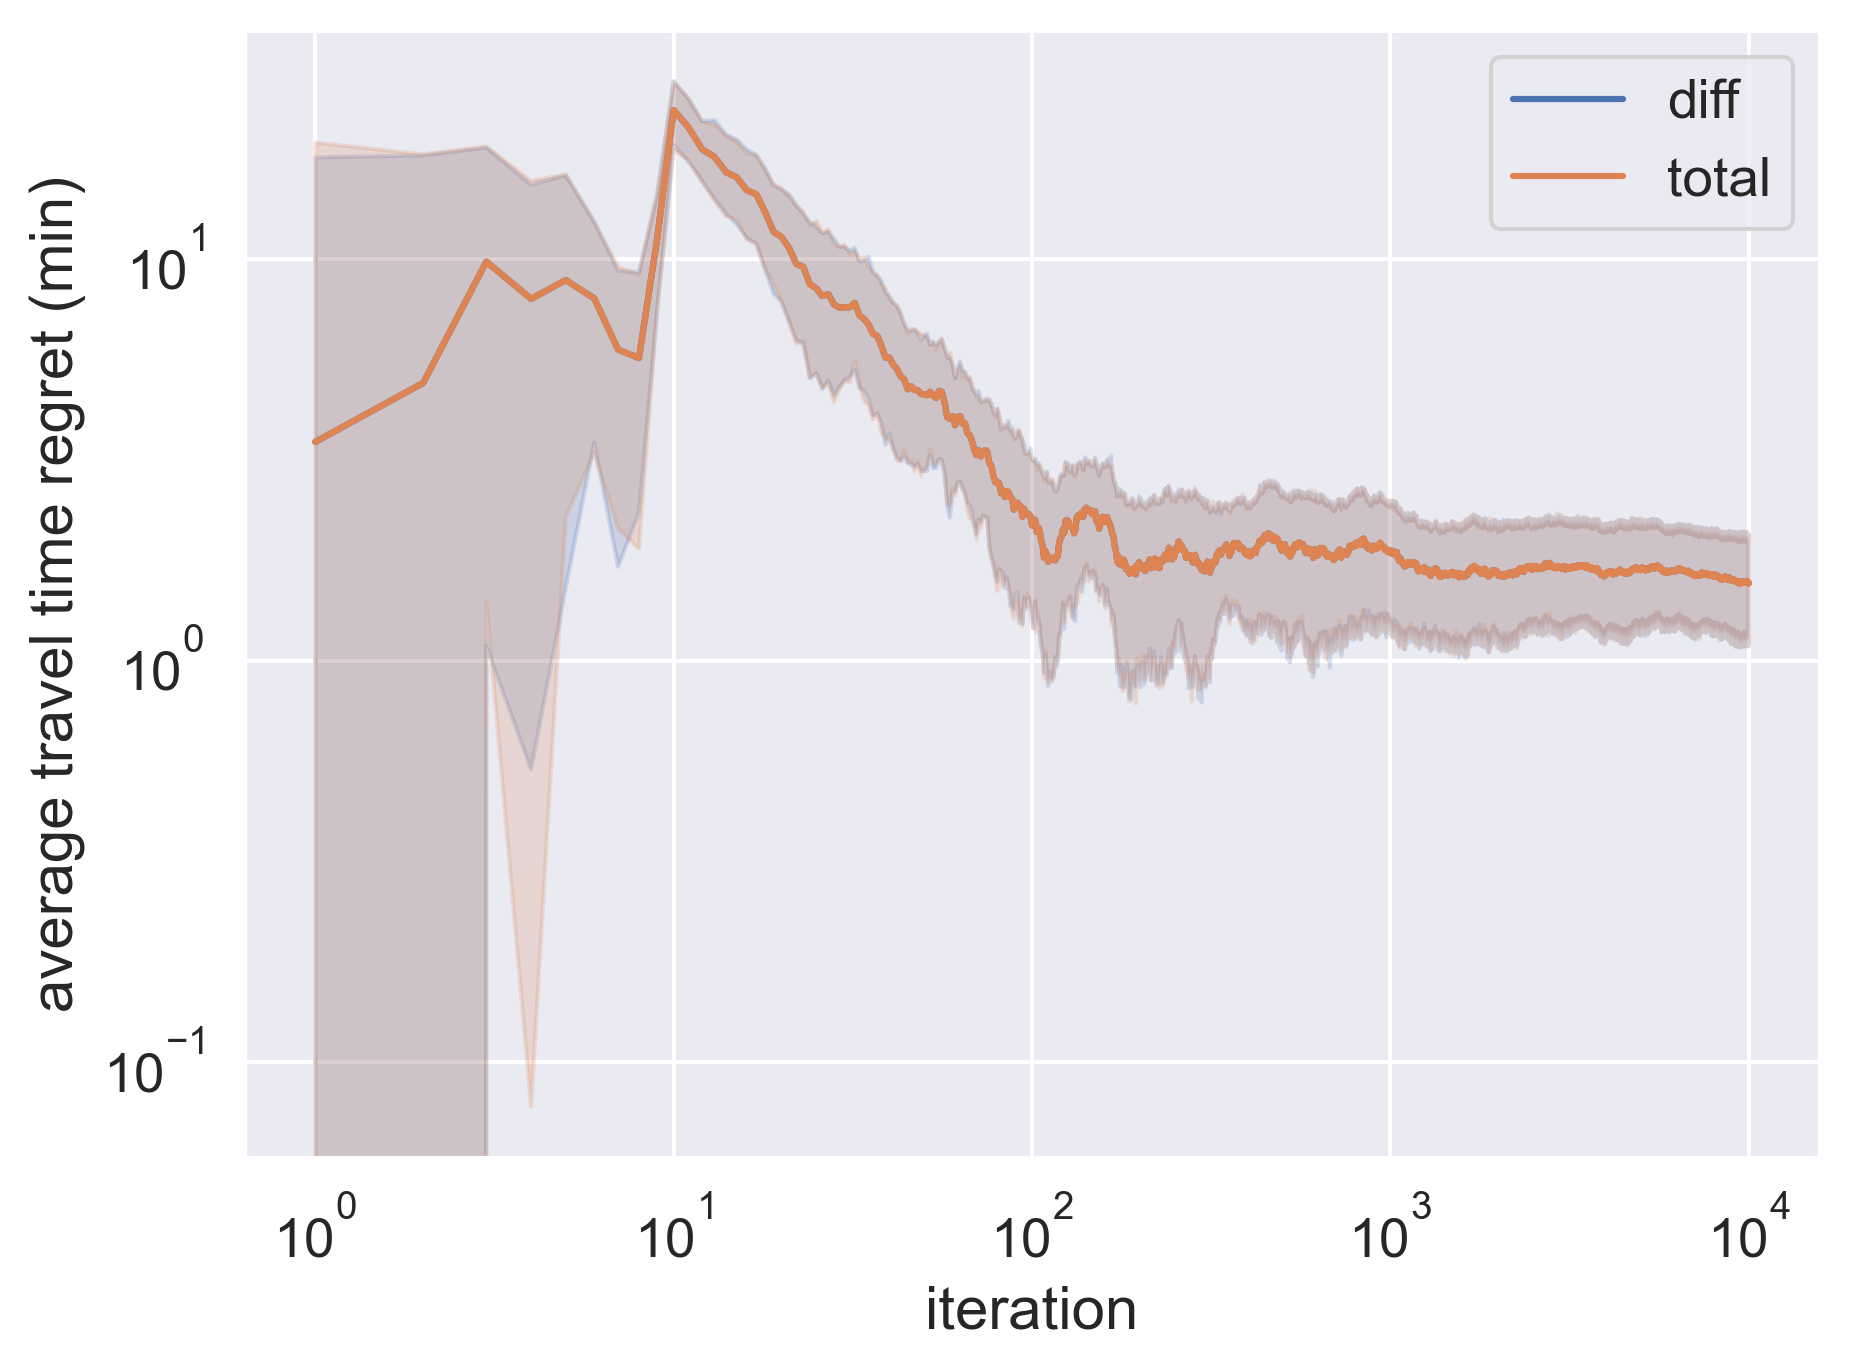

In [31]:
fig_high_var_0p3_final = draw_figure_runs(all_regret_highvar_final, all_regret_highvar_final)

In [122]:
# compute expectation by sample
all_travel_time = []
for l in range(5):
    # get the bandit with trust rate 0.3
    bandit_0p3 = epsilon_greedy_opt.bandit_list[l]
    # for 10000 iterations
    max_iter = 10000
    # initialize a list to store the results
    travel_time = []
    for i in range(max_iter):
        # sample a trust rate by 1e-2 std with normal distribution
        trust_rate = np.random.normal(0.3, 1e-2)
        # get the travel time
        travel_time.append(bandit_0p3.pull(trust_rate))
    all_travel_time.append(travel_time)

In [124]:
for i in range(5):
    print(np.mean(all_travel_time[i]))

524.6588588502827
522.5833796541167
522.912538081369
524.7034761978211
607.1526399267411


In [102]:
for i in range(10):
    print(np.mean(all_travel_time[i]))
# print('empirical average', np.mean(travel_time))
# print('true average', bandit_0p3.solution['time'])


524.5025545521565
522.2234287114672
522.3428499262909
522.618006850675
523.058131402839
523.7363873221367
524.5046604266669
525.4777947517317
607.3549112479122
731.407475852363


In [45]:
print('empirical average', np.mean(travel_time))
print('true average', bandit_0p3.solution['time'])

empirical average 522.4070631632037
true average 521.2414684939039


In [11]:
# (522.7656645810144 - 521.2414684939039) * 0.6
521.2414684939039 * 0.6

312.74488109634234

In [10]:
new_regret = []
for i in range(len(all_results_highvar_final)):
    new_regret.append(
        (np.cumsum(all_results_highvar_final[i]['travel_time']) / (np.arange(10000) + 1) - np.mean(travel_time))
        * 0.6)
# new_regret = all_results_highvar_final

ValueError: operands could not be broadcast together with shapes (50000,) (10000,) 

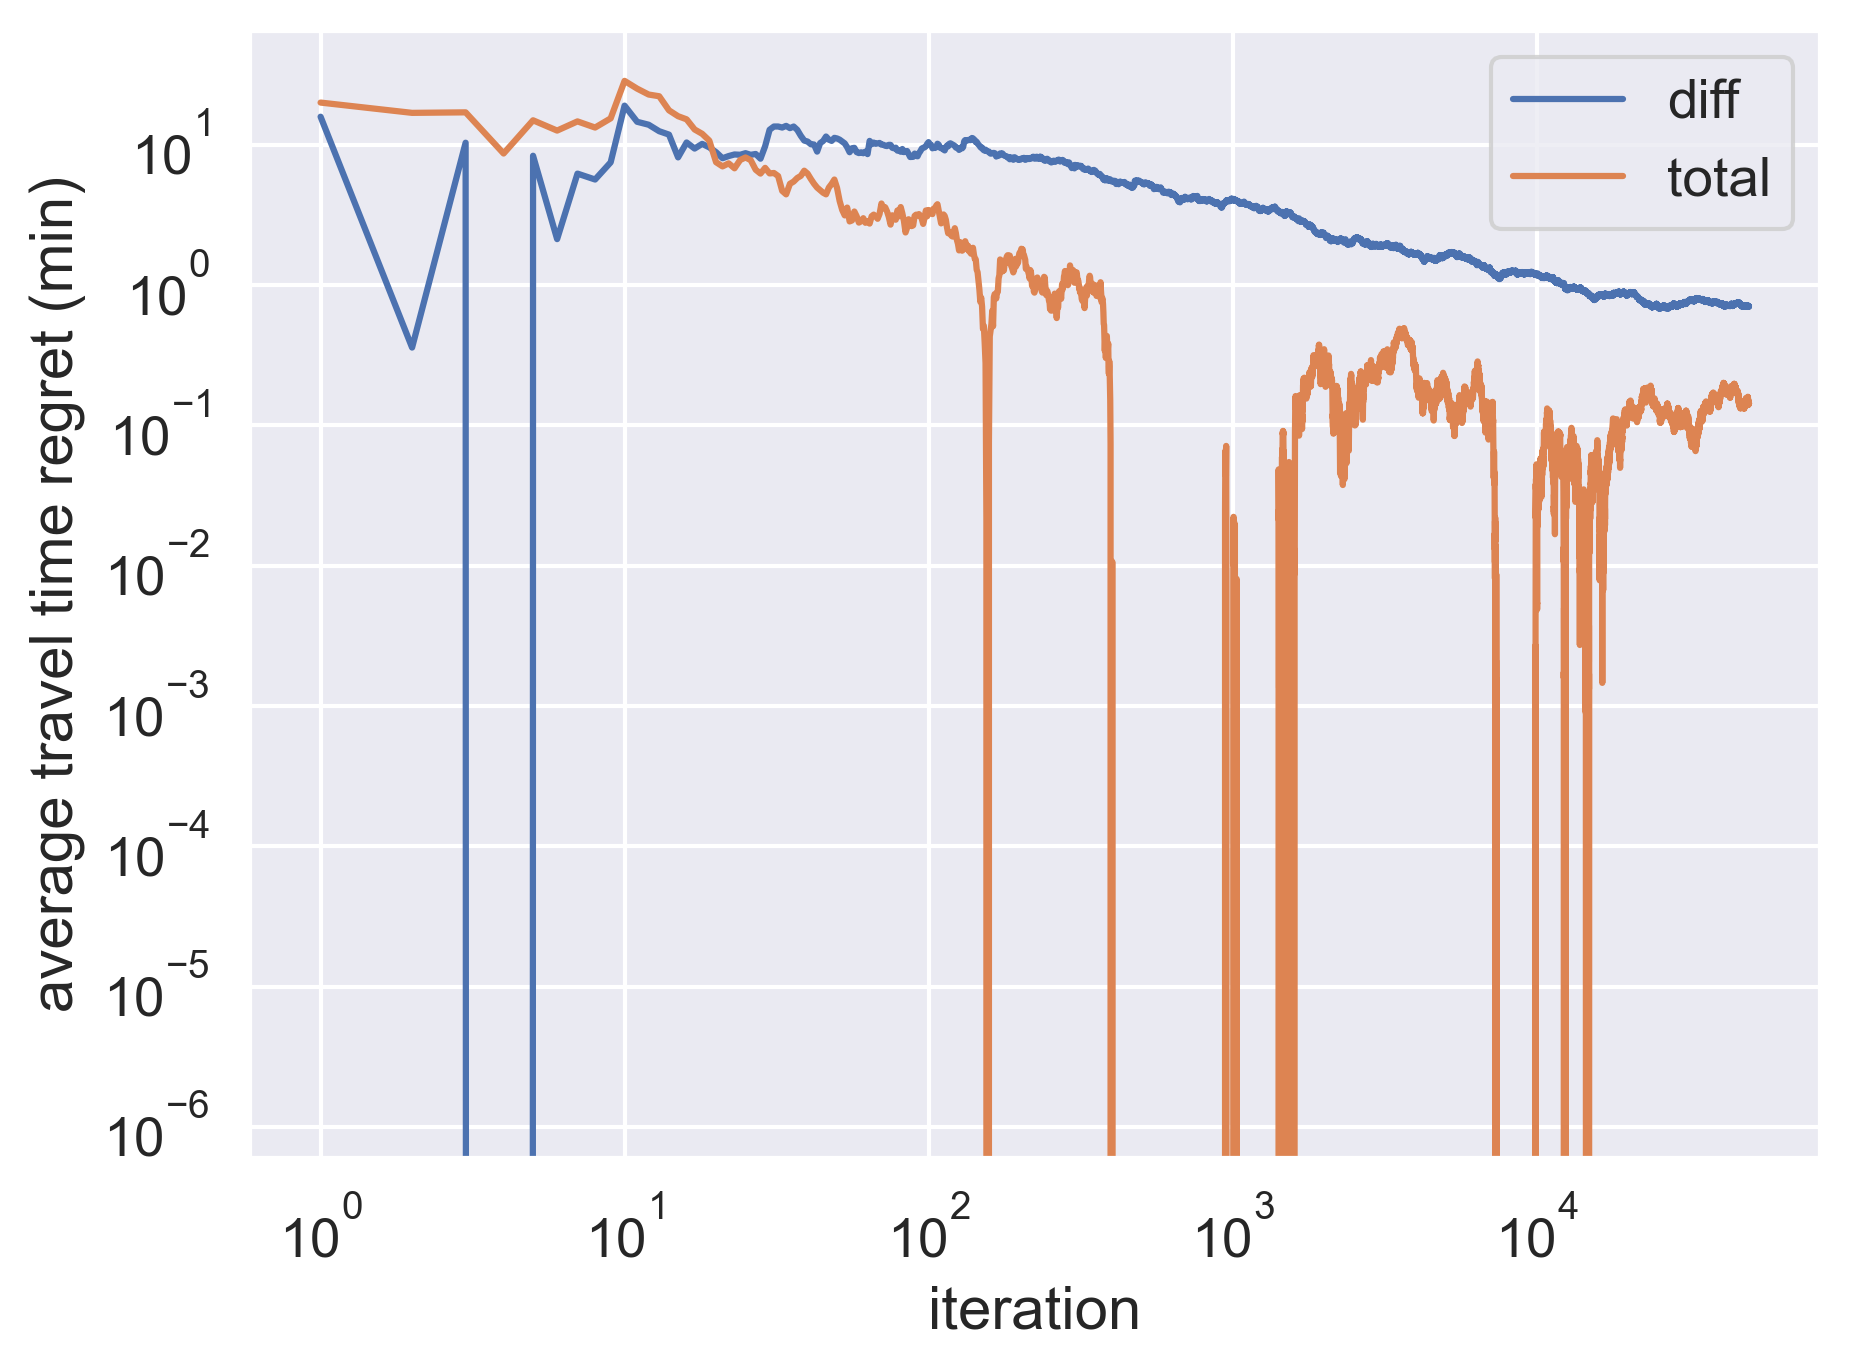

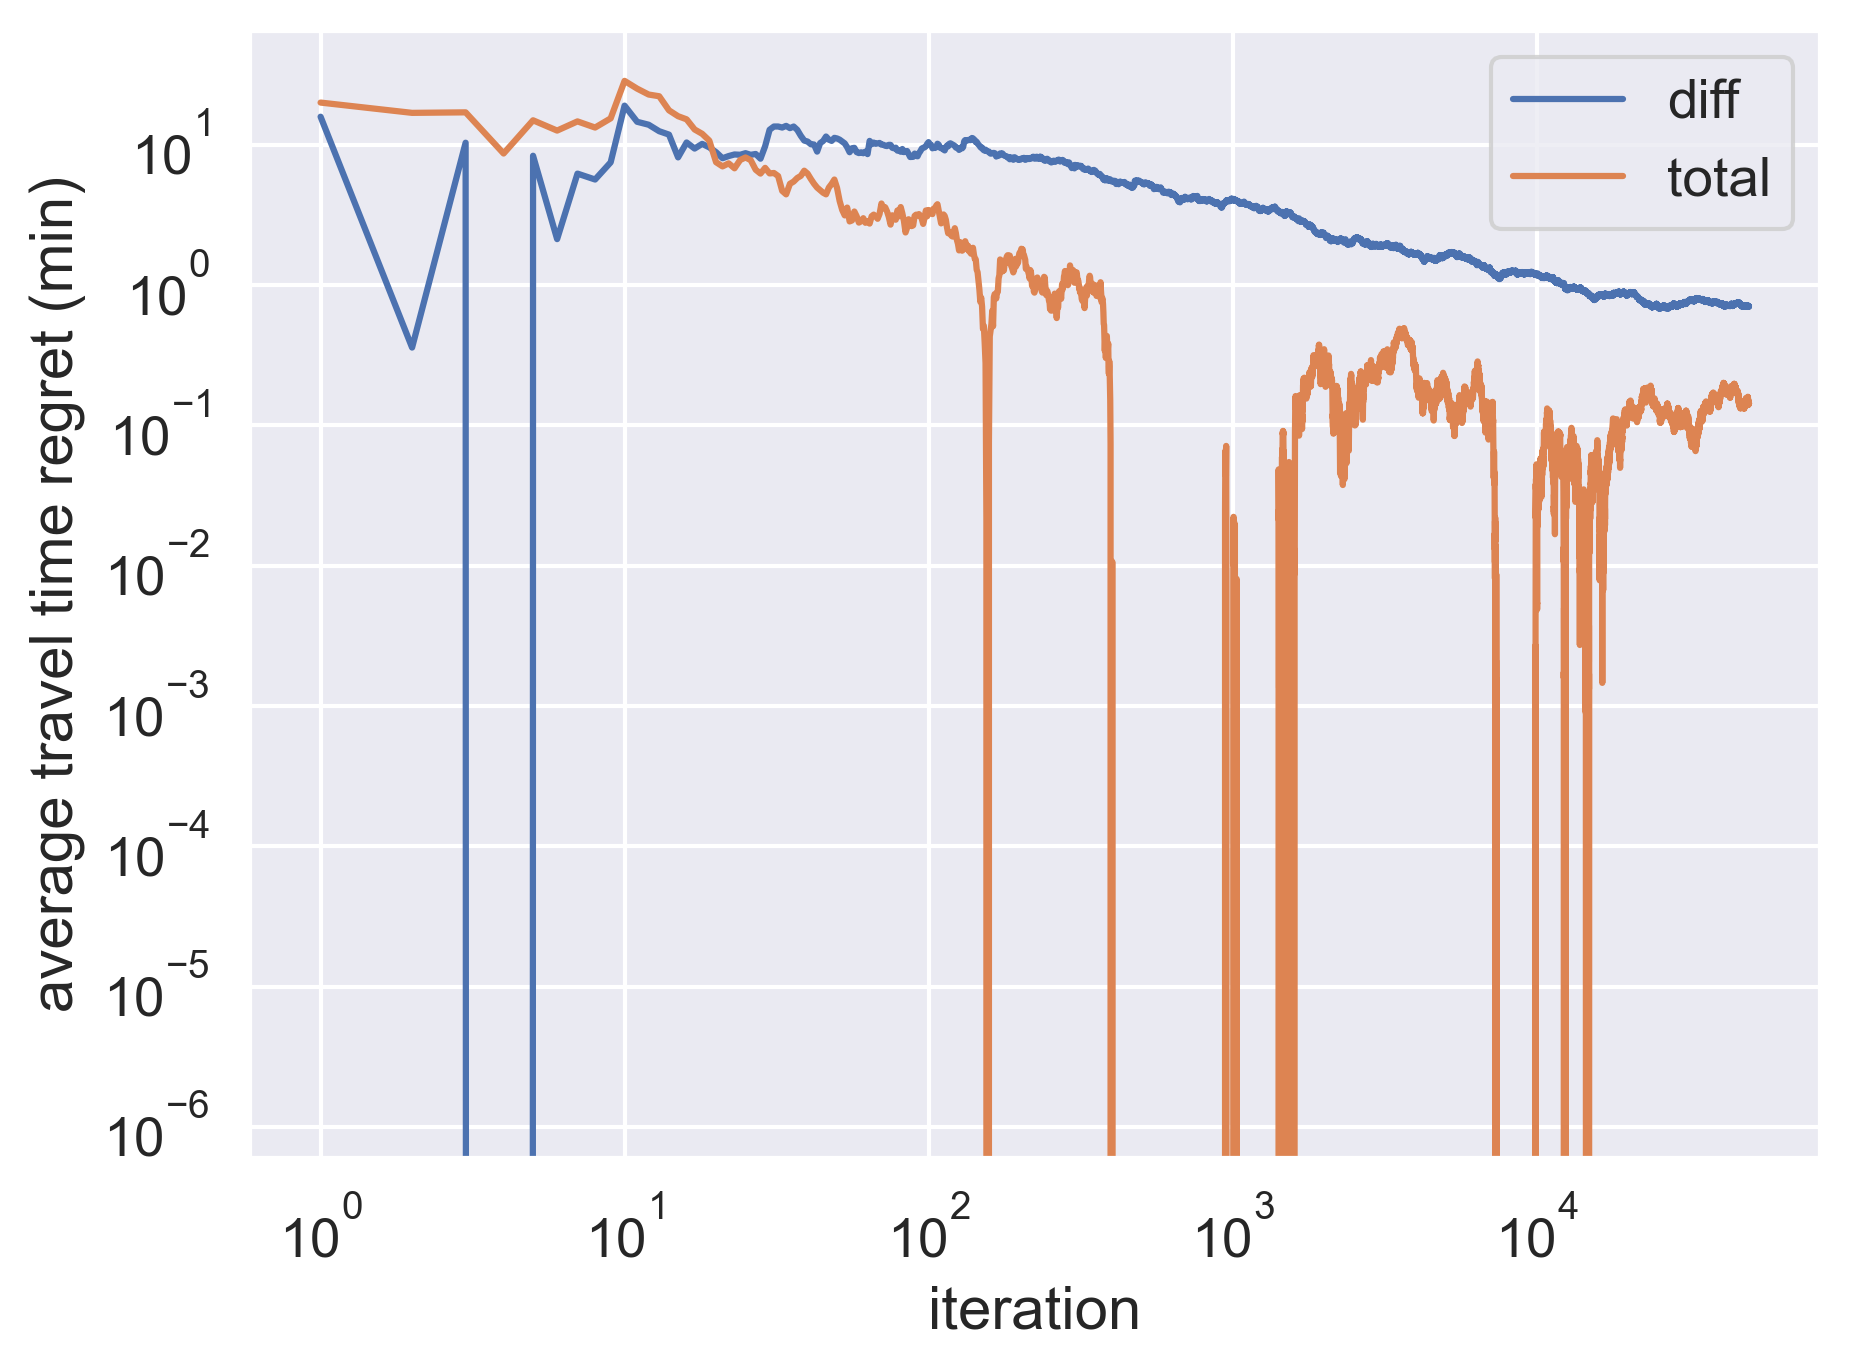

In [109]:
draw_figure_runs(all_regret_final_adjust, all_regret_final_normal)

In [ ]:
all_results_highvar_final[0].keys()

In [83]:
all_results_highvar_final[0]['actions'][-10:]

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [56]:
all_results_highvar_final[0]['pull_time_bandit']


array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 9.986e+03,
       6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00])

In [63]:
all_results_highvar_final[0]['total_time_bandit'] / all_results_highvar_final[0]['pull_time_bandit']

array([523.42893005, 523.79246269, 521.7126131 , 523.55094979,
       523.37411821, 523.60753857, 522.58612979, 525.31840469,
       606.13521179, 731.09787788])

In [73]:
np.sqrt(2 * np.log(10000 + 1) / all_results_highvar_final[0]['pull_time_bandit'])


array([0.12601615, 0.12656286, 0.11322095, 0.10936915, 0.11557744,
       0.12515596, 0.11982346, 0.14915576, 0.68726289, 1.51743537])

In [82]:
all_results_highvar_final[0]['pull_time_bandit']
# epsilon_greedy_opt.compute_upper_bound()

array([1.1090e+03, 2.1522e+04, 5.1470e+04, 1.1301e+04, 8.1380e+03,
       3.6840e+03, 1.9130e+03, 8.5800e+02, 4.0000e+00, 1.0000e+00])

<Axes: >

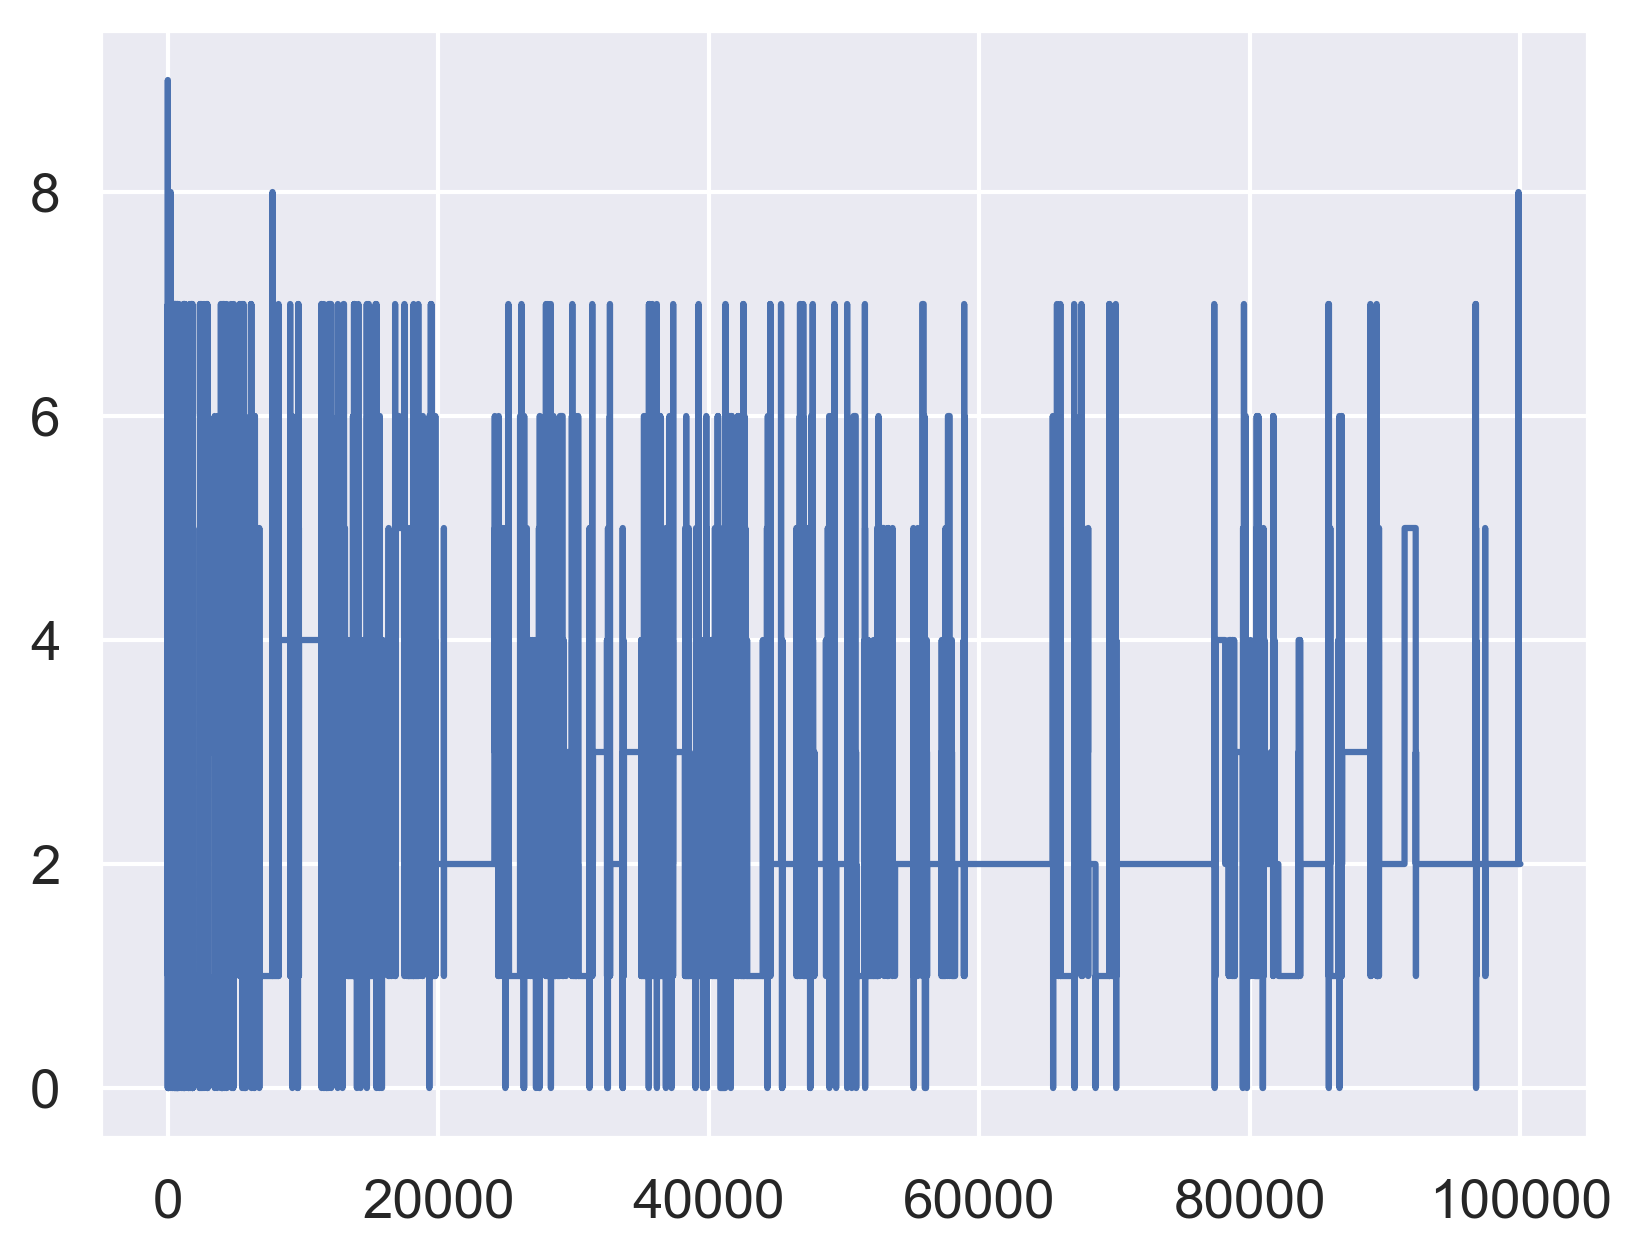

In [85]:
sns.lineplot(x=np.arange(100000) + 1, y=all_results_highvar_final[0]['actions'], errorbar=None)

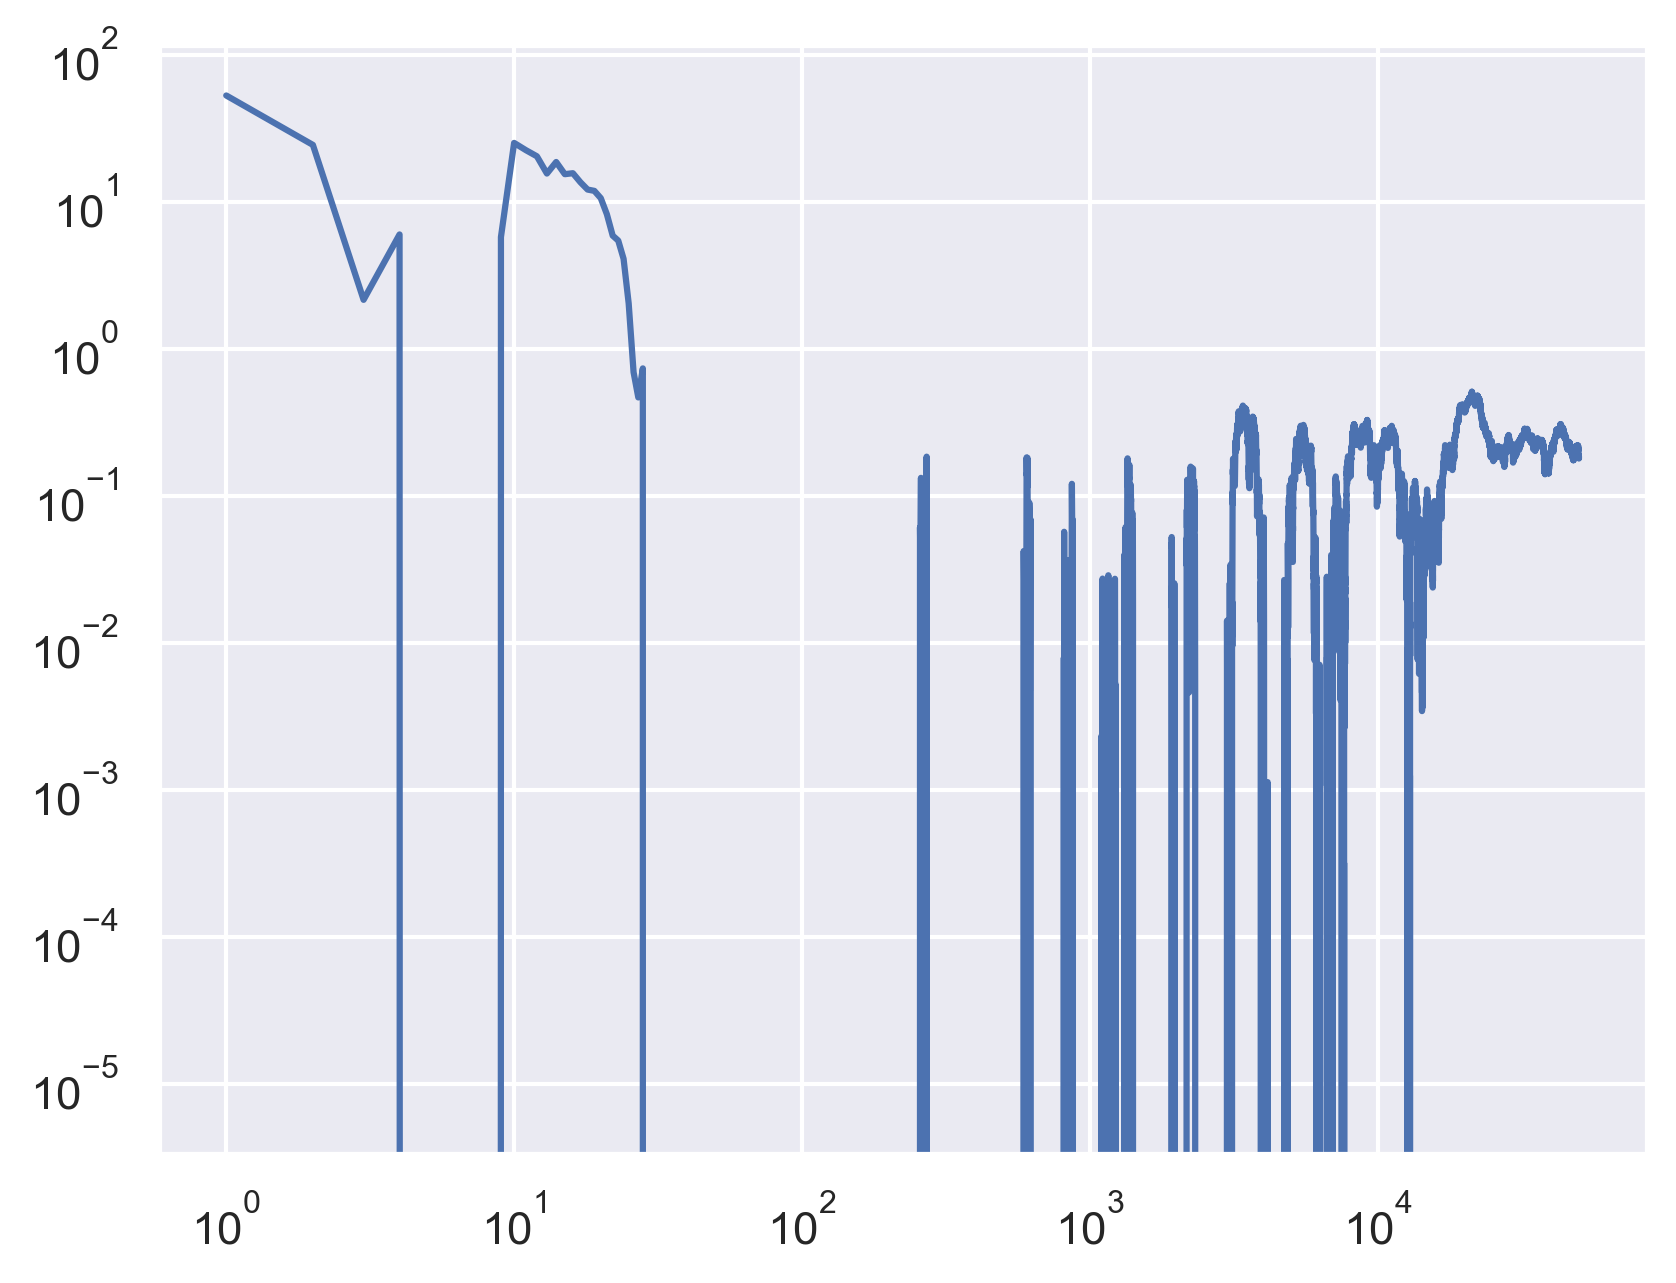

In [18]:
ax = sns.lineplot(x=np.arange(50000) + 1, y=np.cumsum(all_results_highvar_final[0]['travel_time']) / (np.arange(50000) + 1) - 522.3194864331622, errorbar=None)
# set x log scale and y log scale
plt.xscale('log')
plt.yscale('log')


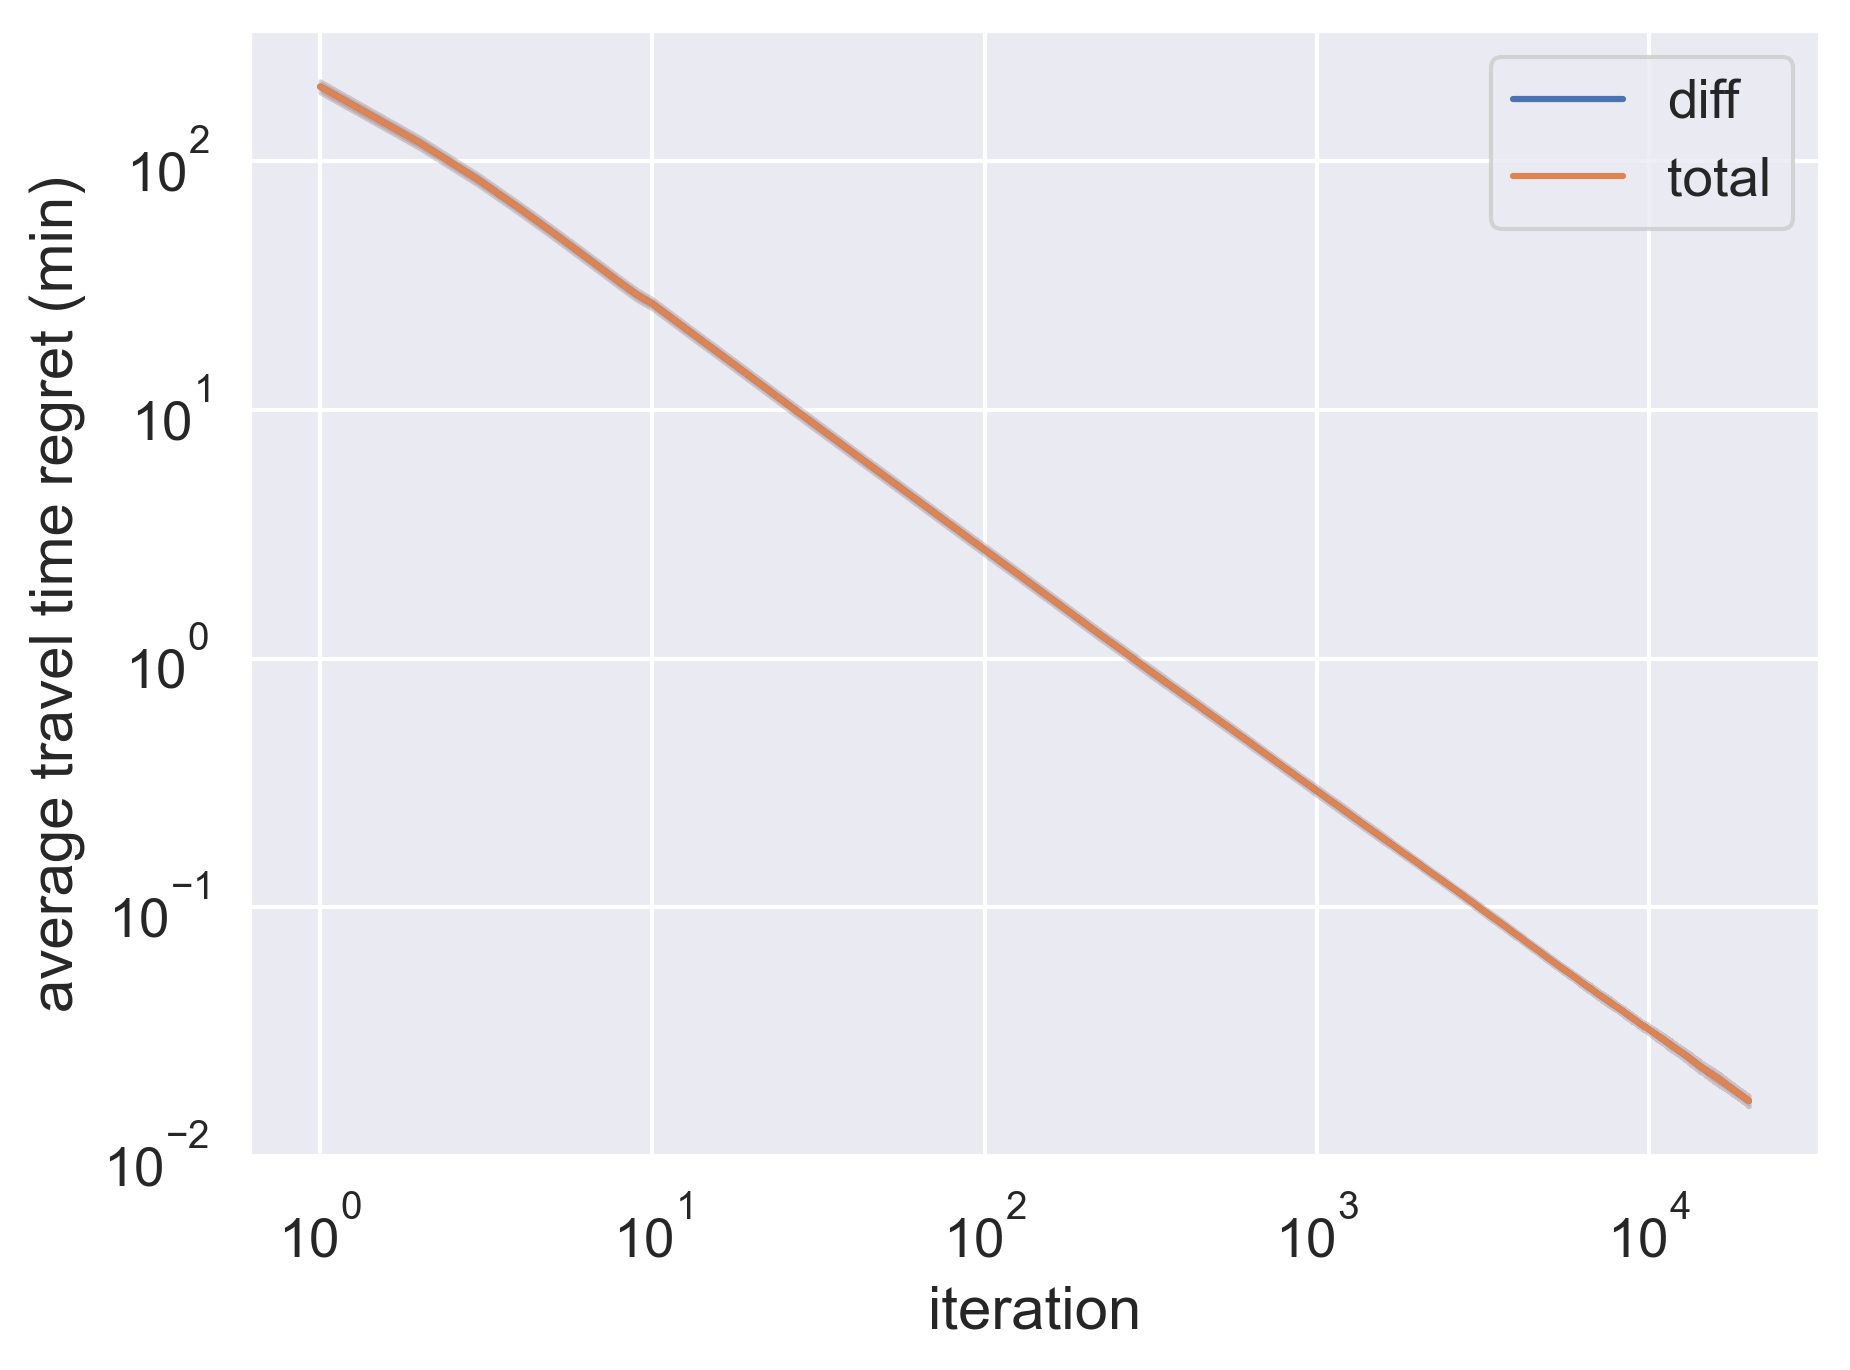

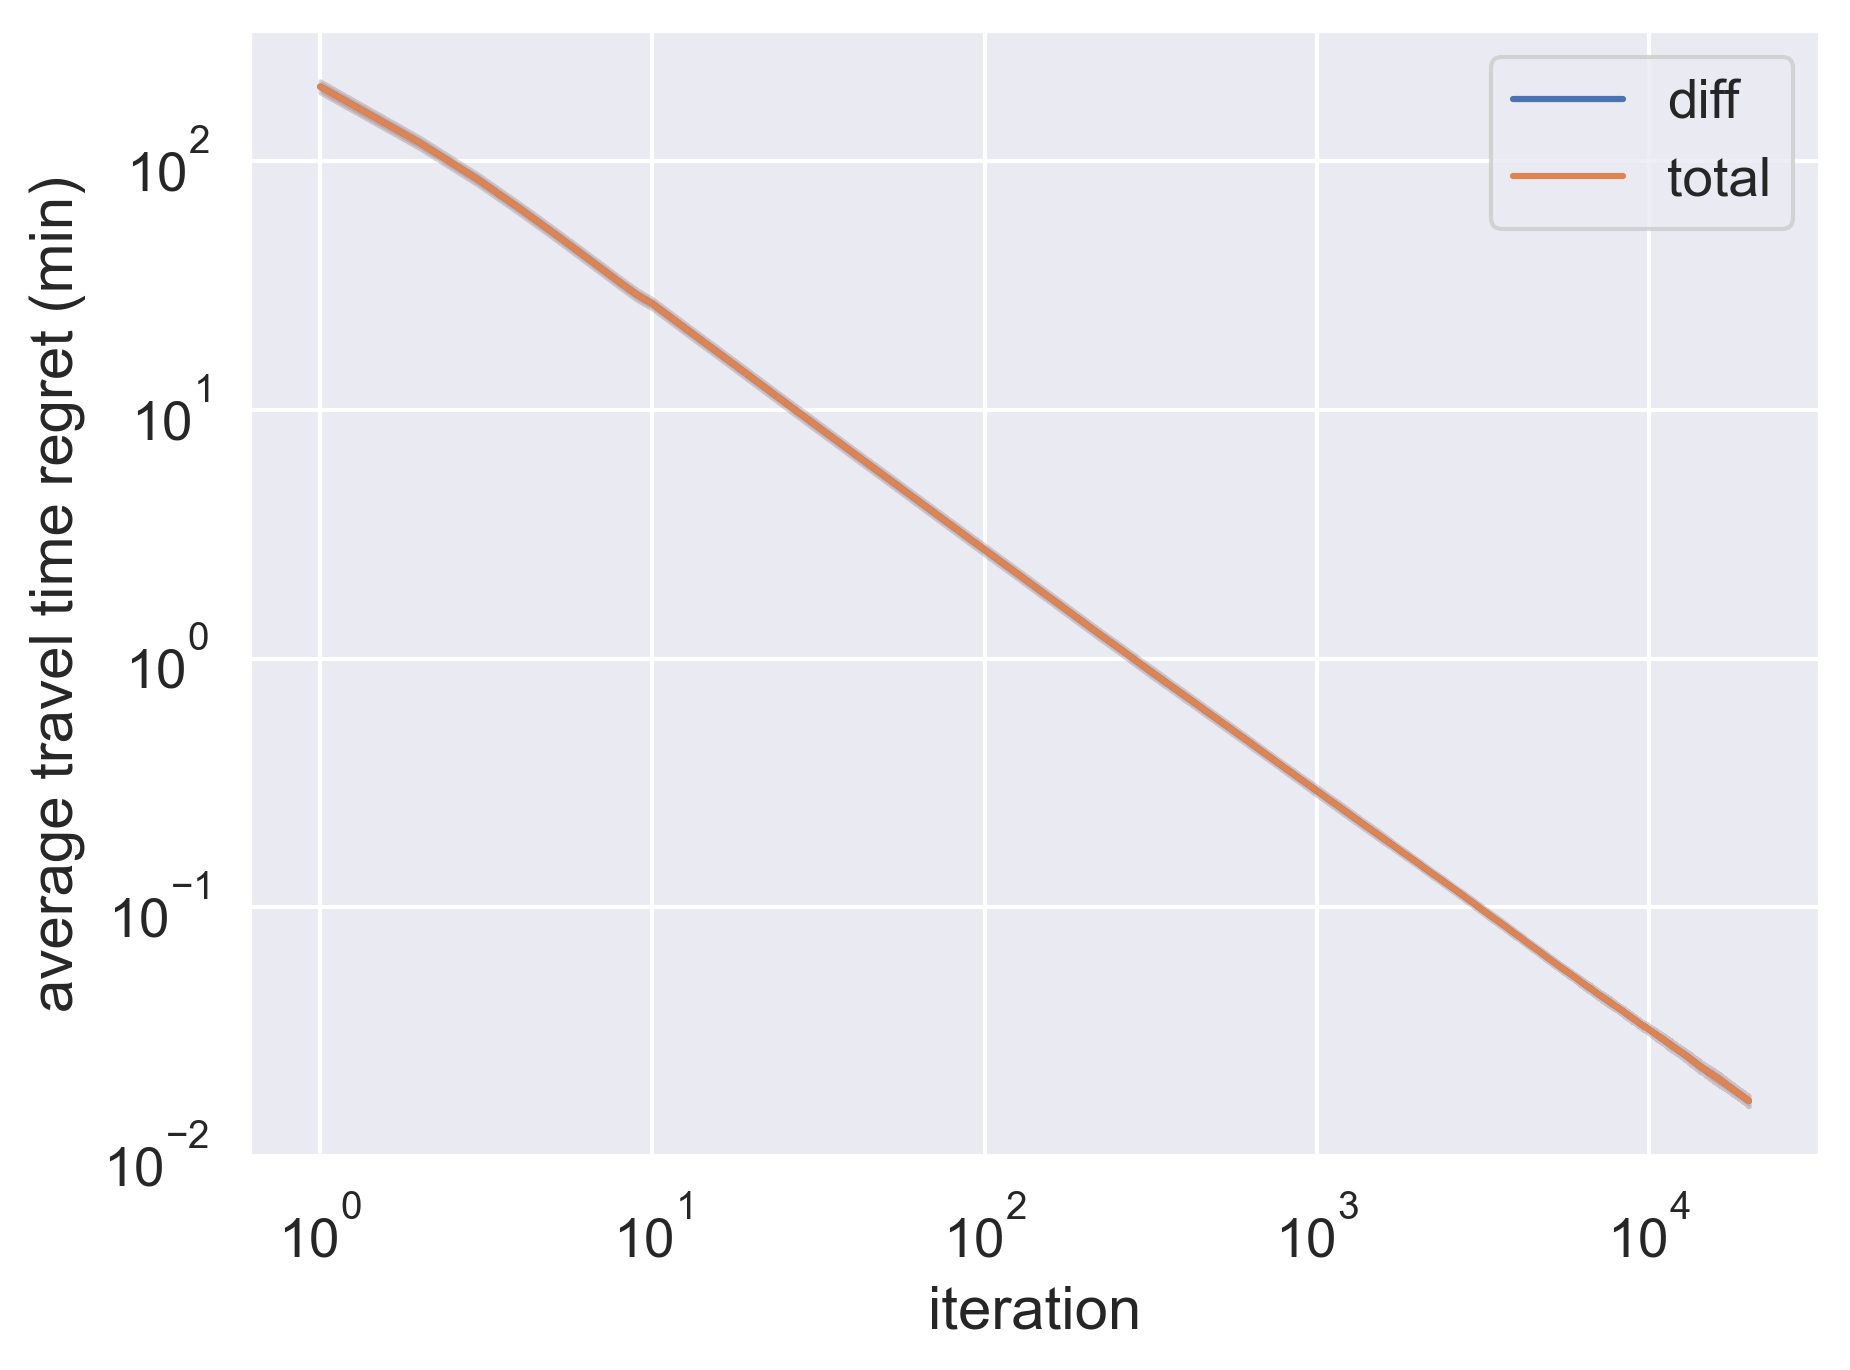

In [63]:
new_regret = []
for i in range(10):
    new_regret.append((np.cumsum(all_results_final_lowite[i]['travel_time']) / (np.arange(20000) + 1) - 14.594346492185402) * 0.6)
draw_figure_runs(new_regret, new_regret)

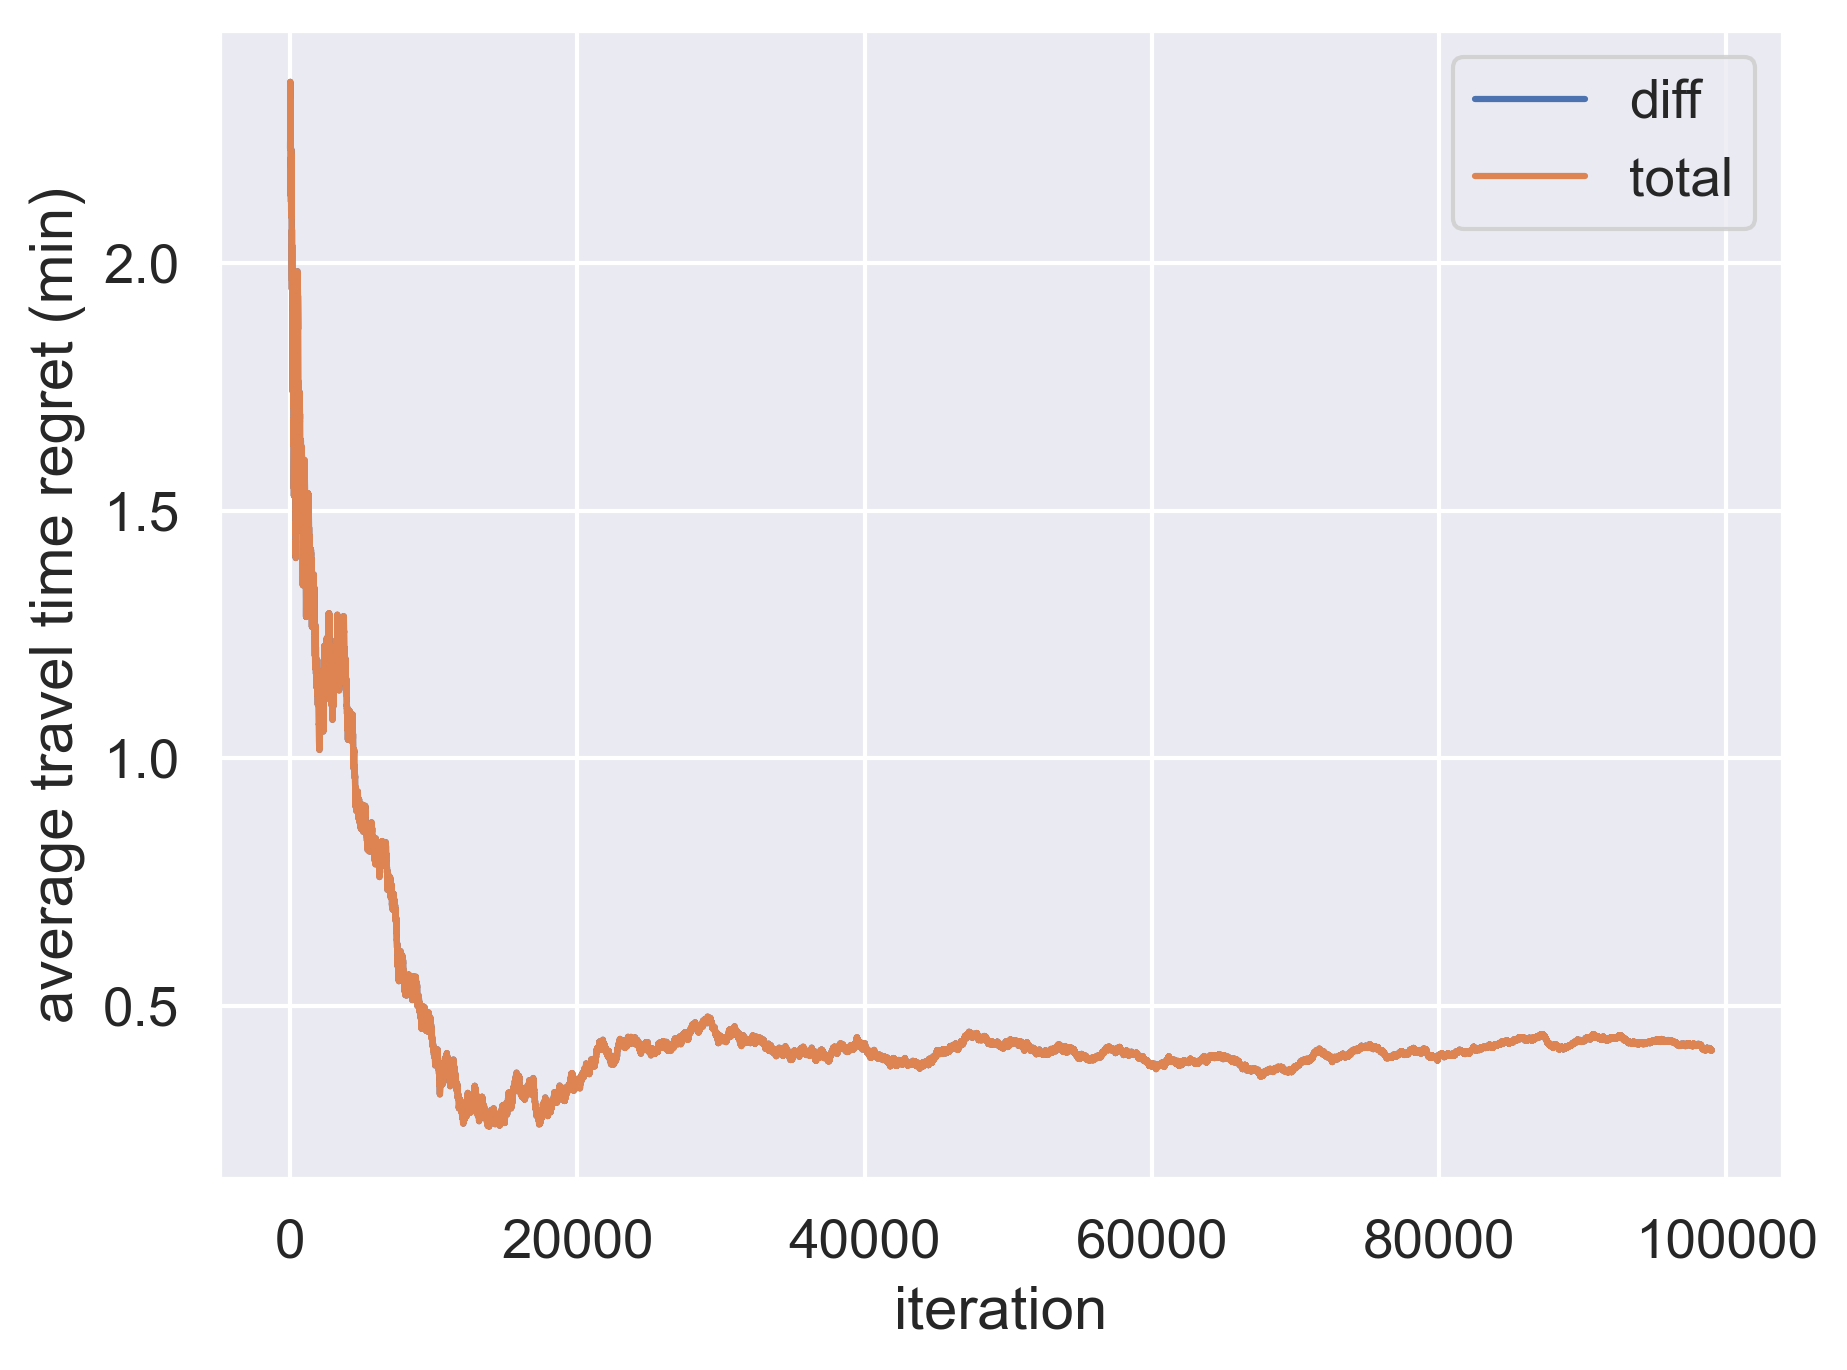

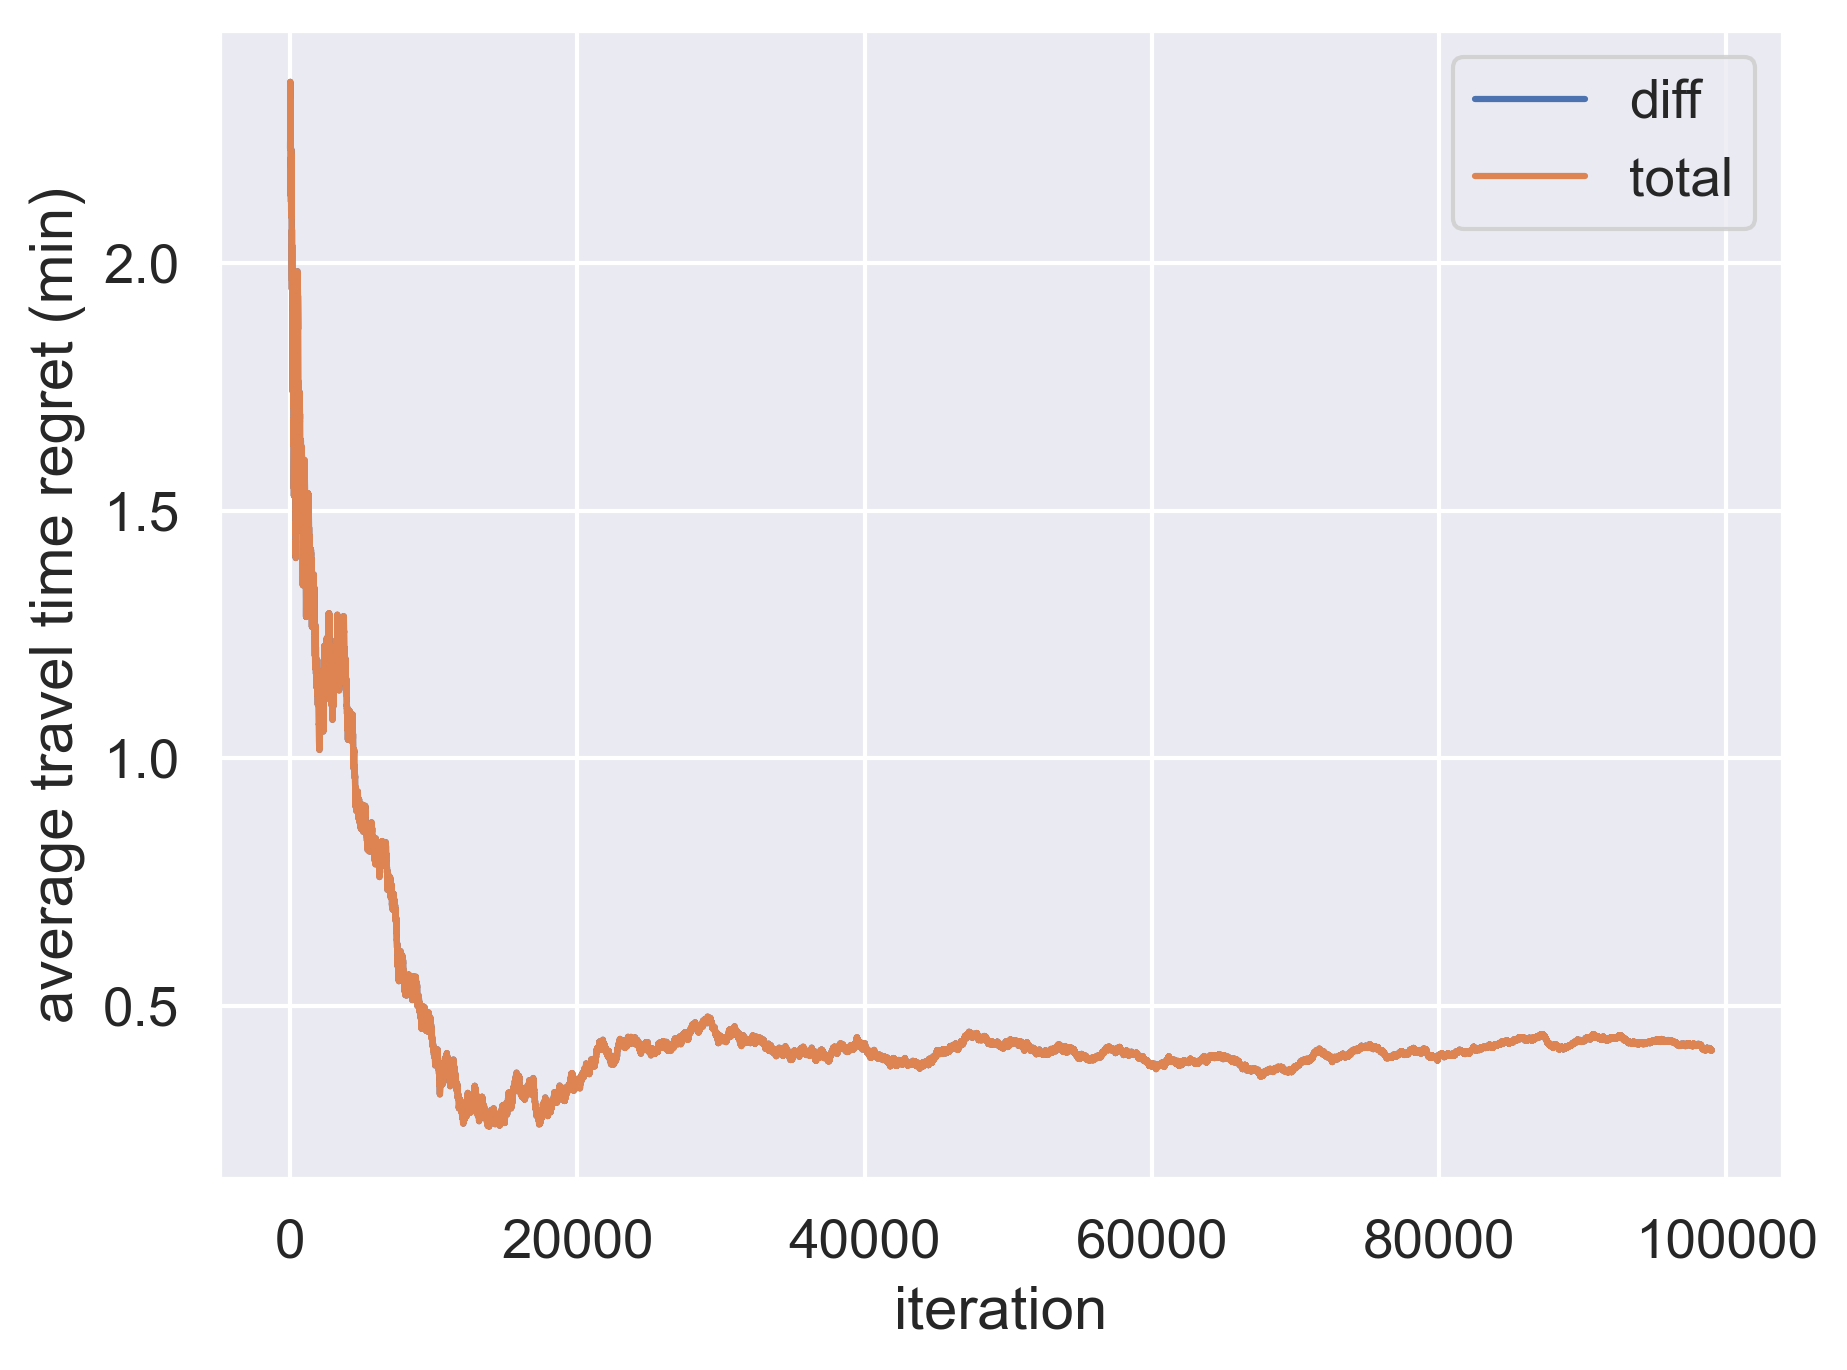

In [93]:
draw_figure_runs([all_regret_final_lowite[0][1000:]], [all_regret_final_lowite[0][1000:]])

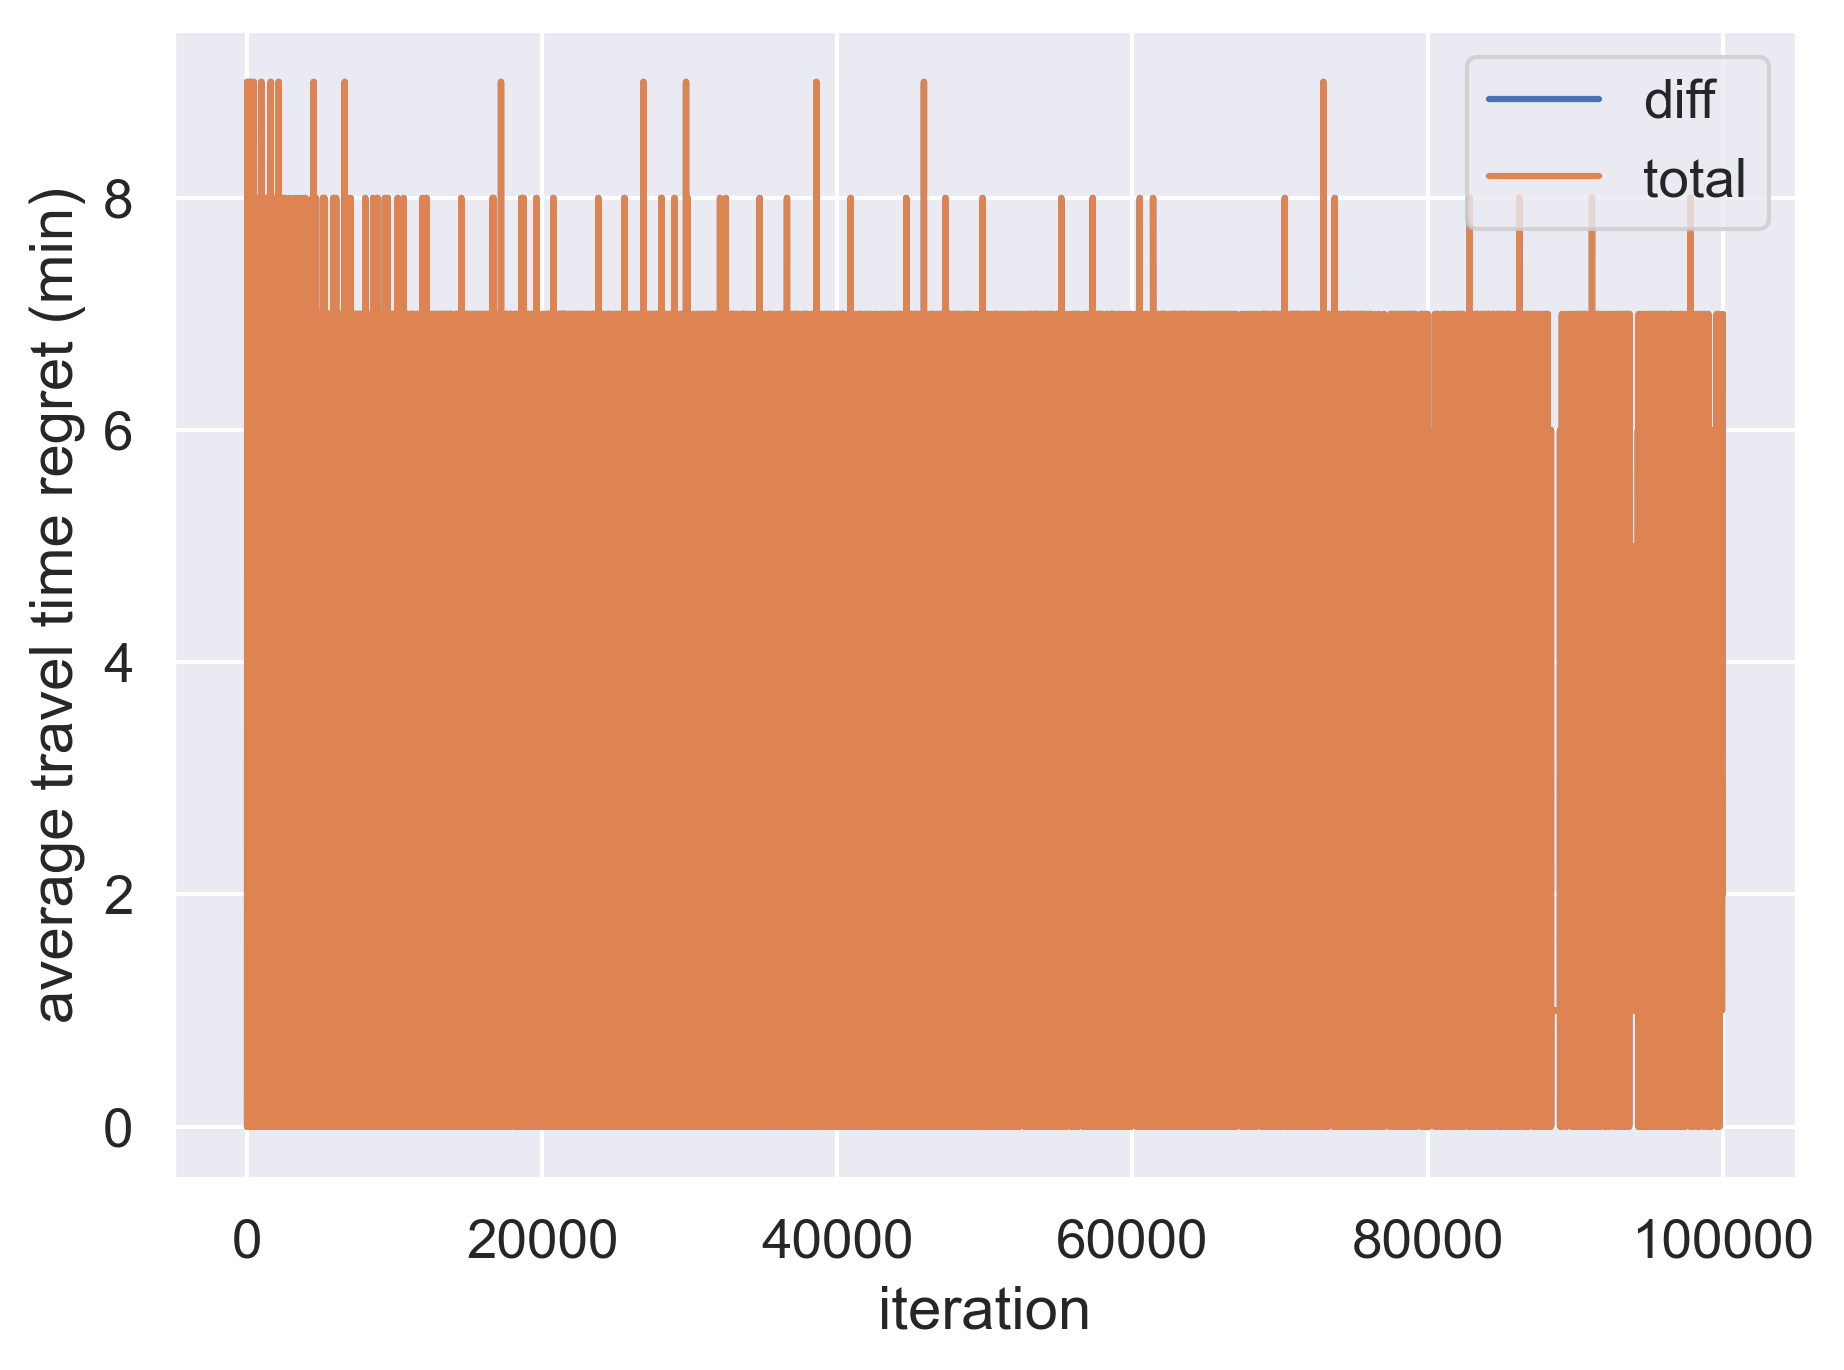

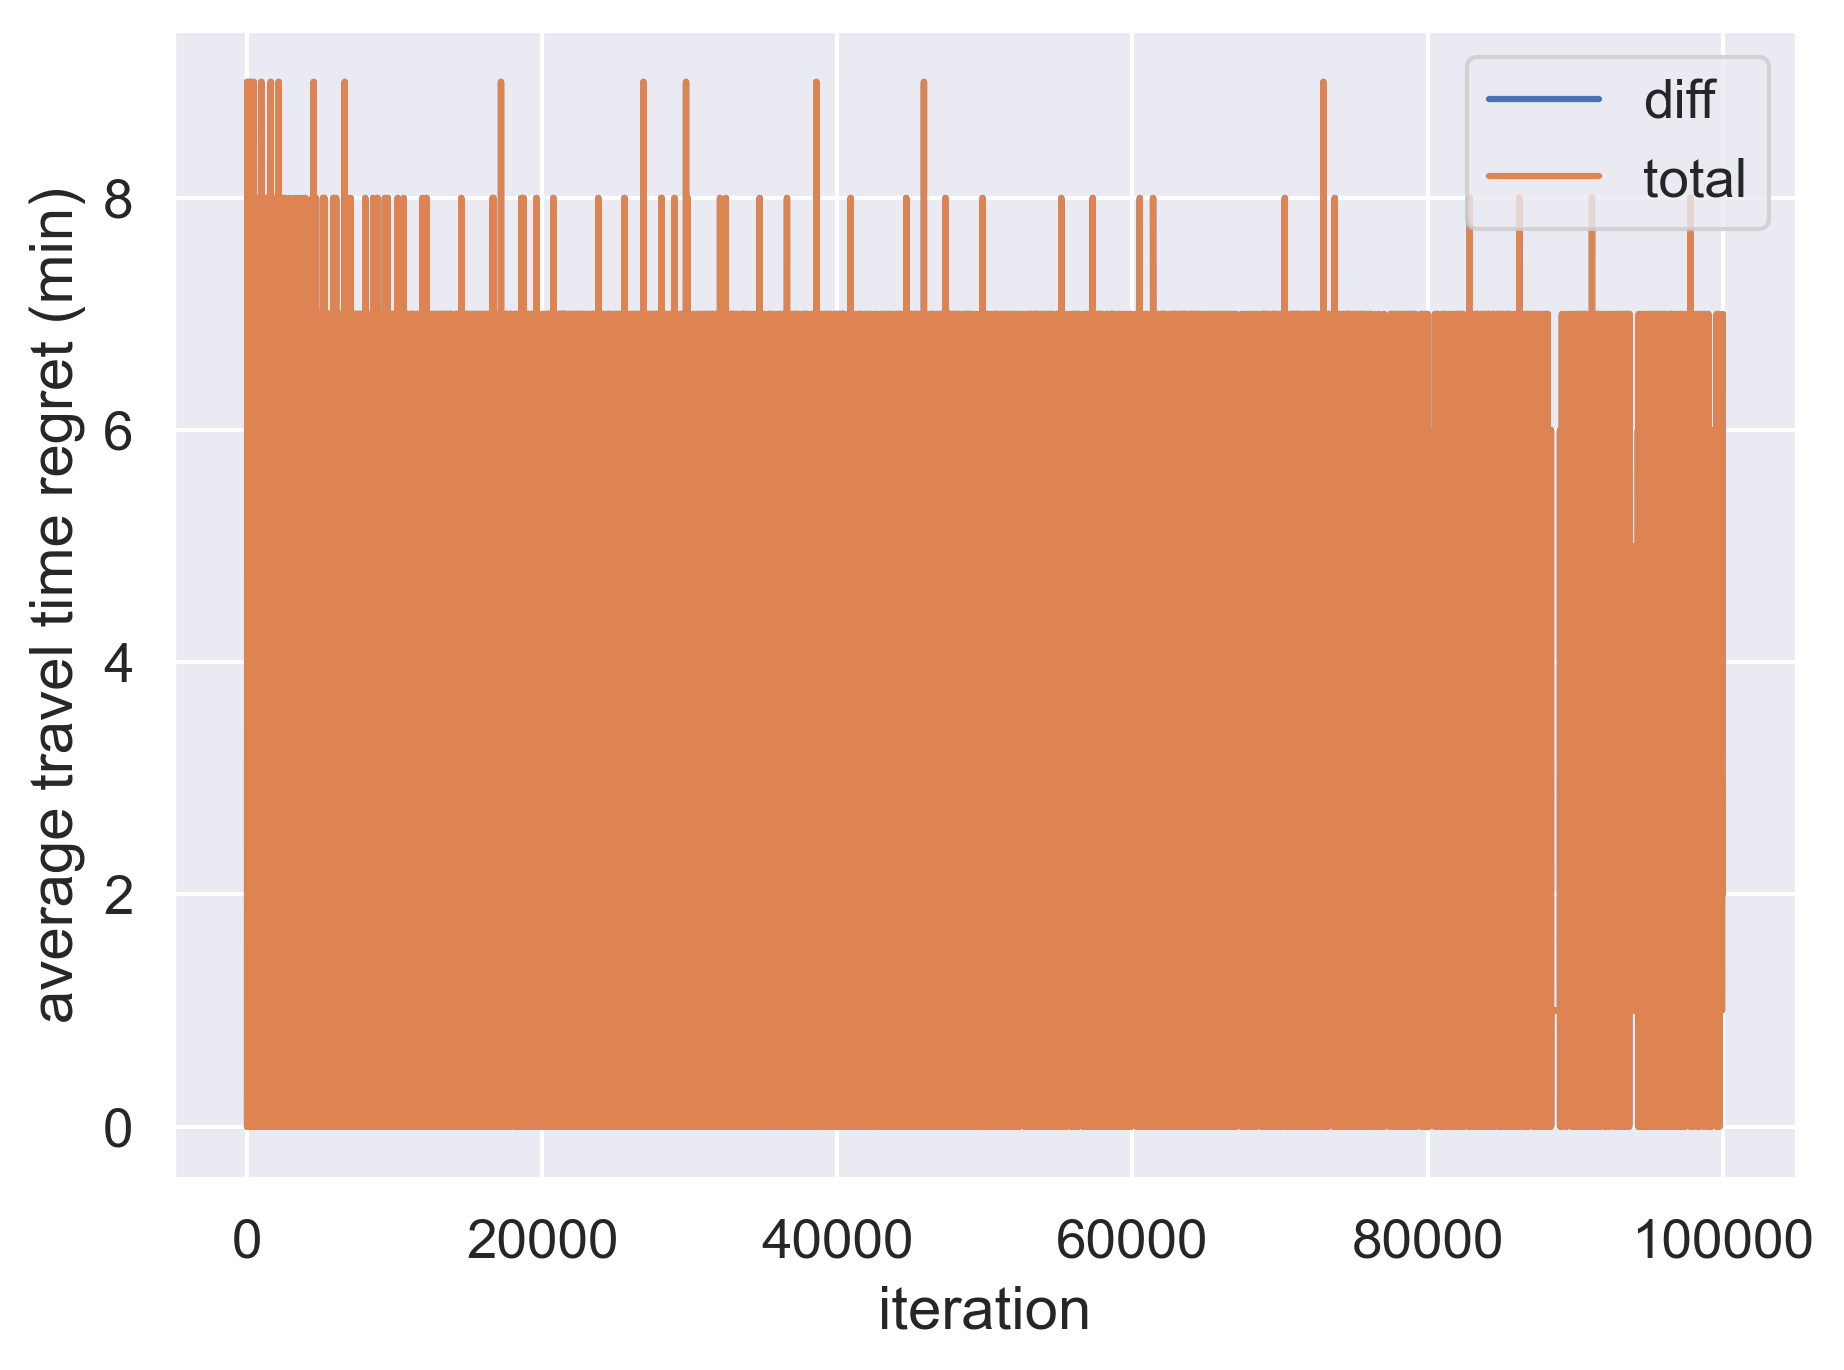

In [95]:
draw_figure_runs([all_results_final_lowite[i]['actions'] for i in range(1)],
                 [all_results_final_lowite[i]['actions'] for i in range(1)])

In [97]:
all_results_final_lowite[0]['actions'][-100:]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7]

In [99]:
all_results_final_lowite[0]['total_time_bandit'] / all_results_final_lowite[0]['pull_time_bandit']

array([524.60105311, 521.94426402, 522.19317465, 522.13319462,
       522.57592805, 522.99040455, 523.69056202, 524.70037427,
       613.85961181, 756.80680939])

In [98]:
time = np.array(all_results_final_lowite[0]['travel_time']) * 0.6
print(np.max(time), np.min(time))

529.0048613421878 230.03934139049167


In [82]:
all_results_final_lowite[3].keys()

IndexError: list index out of range

In [68]:
all_results_final_lowite[3]['sample_trust_list']


[0.29518815799828185,
 0.28905786169191433,
 0.28814346301278326,
 0.2883910759352337,
 0.3100409215809845,
 0.29891649644933915,
 0.292912894042791,
 0.29622091640046916,
 0.29791520058799437,
 0.30148669475177536,
 0.29509377197729836,
 0.3057970456061841,
 0.31067695528975786,
 0.31643143833615356,
 0.30993421646009156,
 0.2917587413822398,
 0.2992993583314215,
 0.28698945337180537,
 0.2800383104490393,
 0.31724724722692843,
 0.3067881945473584,
 0.3172192069763585,
 0.2986090339244481,
 0.30398784946860147,
 0.28614340008778244,
 0.30154341347504676,
 0.29253341090569057,
 0.2972026085585455,
 0.2990662434402037,
 0.28714081675432024,
 0.30858506463876506,
 0.29726755108190744,
 0.30495391490031587,
 0.31582452628571767,
 0.306726835375077,
 0.3057986108807701,
 0.2927358751501403,
 0.3049496691207484,
 0.31613948688870075,
 0.2914561513517514,
 0.29467564075176583,
 0.2836561588718268,
 0.29610348813469156,
 0.32031309418924714,
 0.31528745651296597,
 0.3020842588906787,
 0.306058

In [78]:
slides_regret_high, slides_result_high = test_bandit_single_trust(0.8, reward_way='final', num_runs=10,
                                                                             std=1e-3, num_ite=1e4)
slides_regret_low, slides_result_low = test_bandit_single_trust(0.3, reward_way='final', num_runs=10,
                                                                             std=1e-3, num_ite=1e4)

At iteration 1000, the cumulative average travel time is 9.034642439745731, and the regret is 0.2945941451187735
At iteration 2000, the cumulative average travel time is 8.89153580131718, and the regret is 0.15148750669022418
At iteration 3000, the cumulative average travel time is 8.84272351038568, and the regret is 0.10267521575872286
At iteration 4000, the cumulative average travel time is 8.818533402620508, and the regret is 0.07848510799355068
At iteration 5000, the cumulative average travel time is 8.803503097971461, and the regret is 0.06345480334450428
At iteration 6000, the cumulative average travel time is 8.793419958045703, and the regret is 0.053371663418745996
At iteration 7000, the cumulative average travel time is 8.786119396140185, and the regret is 0.04607110151322722
At iteration 8000, the cumulative average travel time is 8.780684471662642, and the regret is 0.0406361770356856
At iteration 9000, the cumulative average travel time is 8.776413580948082, and the regret 

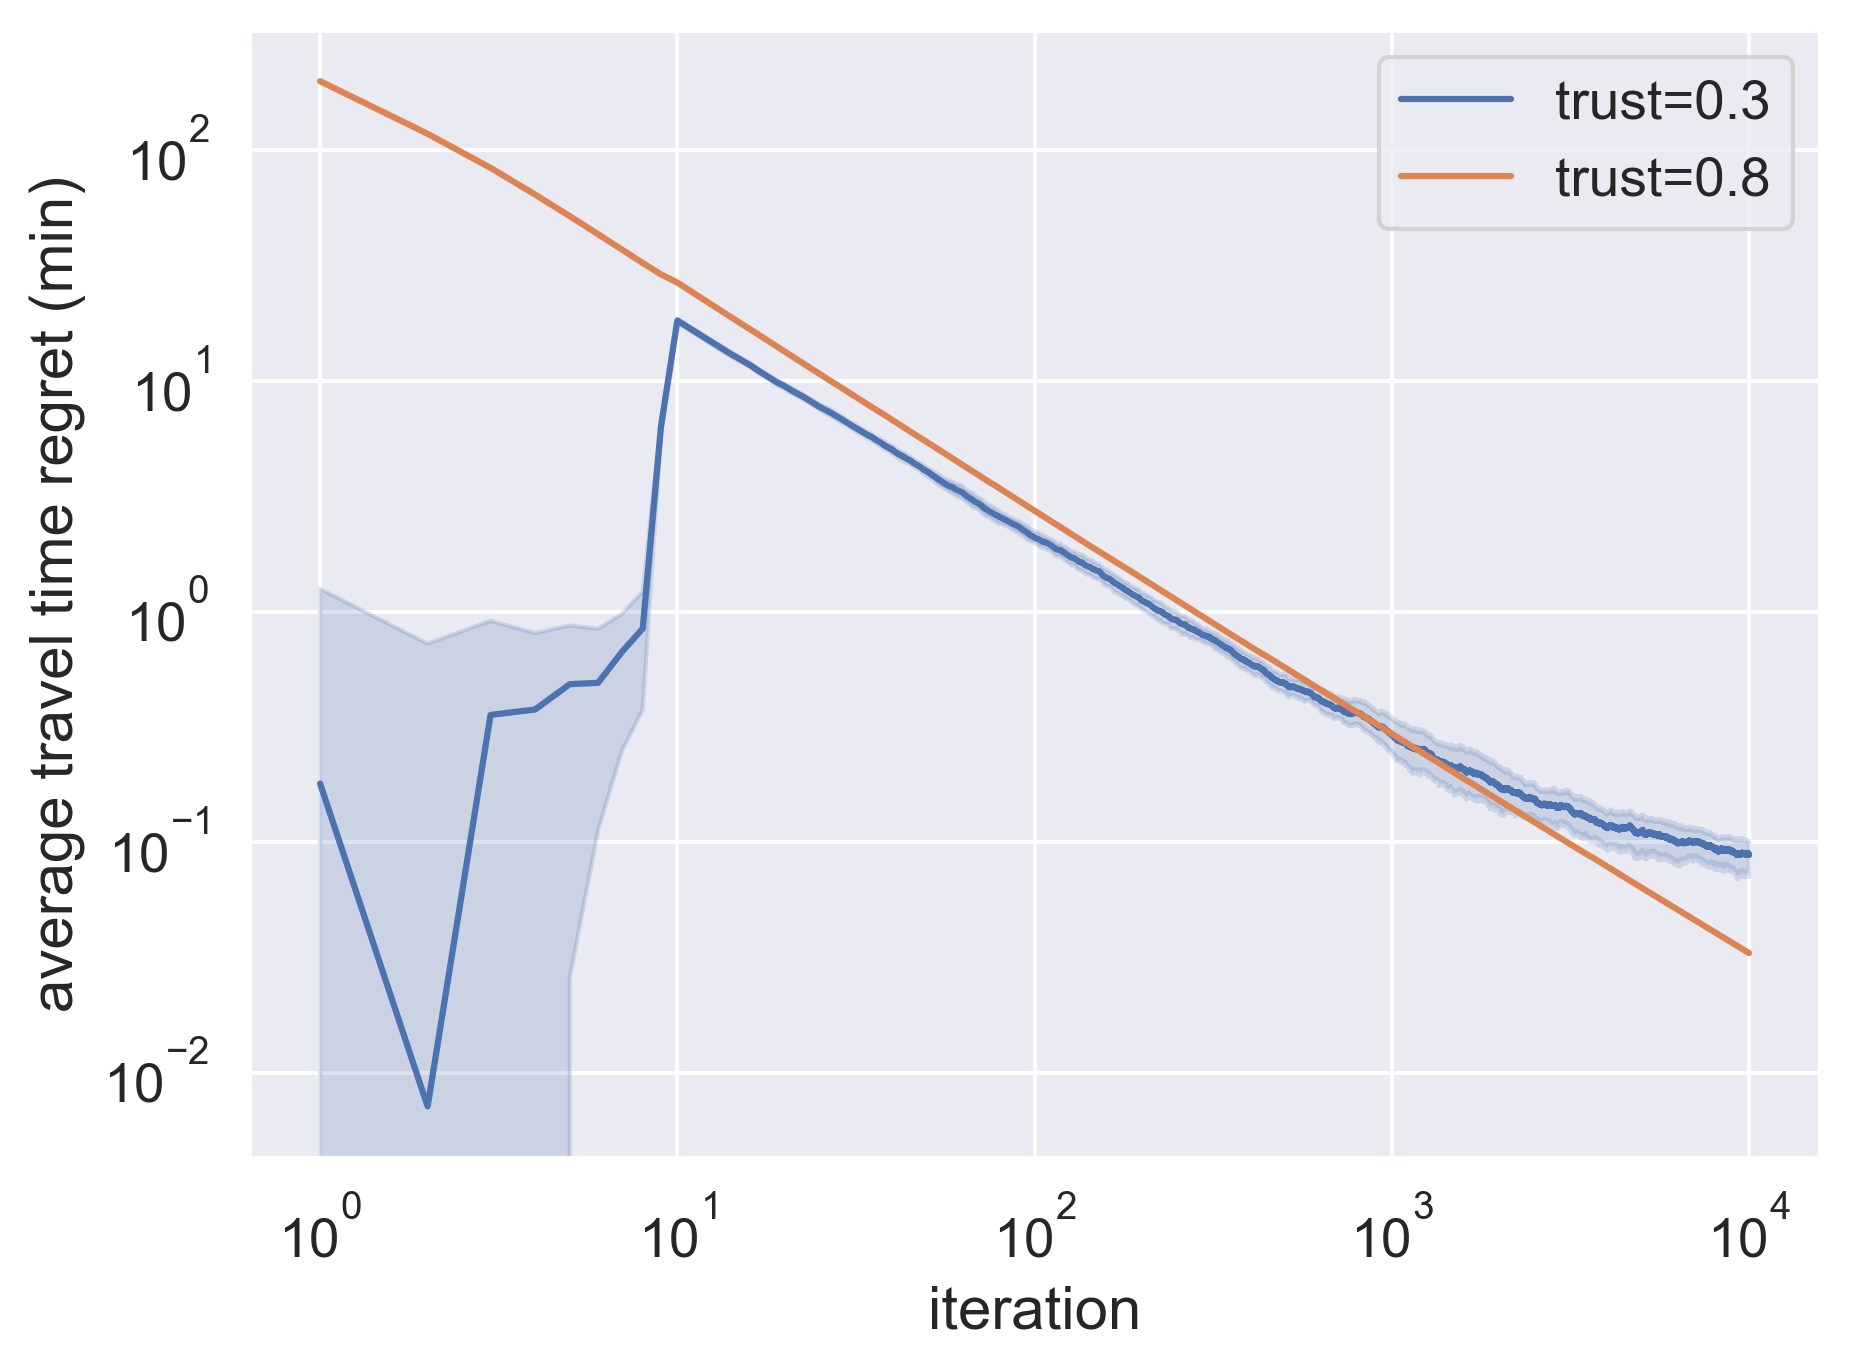

In [81]:
for all_regret, label in zip([slides_regret_low, slides_regret_high], ['trust=0.3', 'trust=0.8']):
    regret_df = pd.DataFrame(all_regret).T
    regret_df['iteration'] = regret_df.index + 1
    # melt with iteration
    regret_df_melt = pd.melt(regret_df, id_vars=['iteration'], value_vars=regret_df.columns[:-1],
                             value_name='regret')
    # draw figure
    ax = sns.lineplot(x='iteration', y='regret', data=regret_df_melt, label=label, errorbar='ci')
    # set sns font scale
sns.set(font_scale=1.2)
ax.set(xlabel='iteration', ylabel='average travel time regret (min)')
plt.yscale('log')
plt.xscale('log')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('../bandit_figure/2trust_for_slides.png', dpi=300)